In [1]:
#Data manipulation and analysis
import pandas as pd
#	Numerical computations
import numpy as np
#Used for working with date and time data (timestamps, time differences, etc.).
from datetime import datetime, timedelta
 # For marking holiday flights,Detects whether a given date is a public holiday
import holidays
#Data Visualization,Helps create plots and charts for data visualization.
import matplotlib.pyplot as plt
# Statistical Data Visualization.
import seaborn as sns
#fetching external data from APIs or web services
import requests
 #Measures execution time and adds delays,Performance Measurement & Delays
import time

Load and Explore the Dataset

In [2]:
# Load dataset
file_path = '/content/Data_Train (3).xlsx' # Replace with your dataset path
data = pd.read_excel(file_path)

Size of data set

In [3]:
#Displays the number of rows and columns in the dataset.
data.shape

(10683, 11)

Inspect the dataset

In [4]:
#Displays the first three rows of the dataset
data.head(3)

Airline Date_of_Journey    Source Destination                  Route  \
0       IndiGo      24/03/2019  Banglore   New Delhi              BLR → DEL   
1    Air India       1/05/2019   Kolkata    Banglore  CCU → IXR → BBI → BLR   
2  Jet Airways       9/06/2019     Delhi      Cochin  DEL → LKO → BOM → COK   

  Dep_Time  Arrival_Time Duration Total_Stops Additional_Info  Price  
0    22:20  01:10 22 Mar   2h 50m    non-stop         No info   3897  
1    05:50         13:15   7h 25m     2 stops         No info   7662  
2    09:25  04:25 10 Jun      19h     2 stops         No info  13882

In [5]:
data.iloc[-2:]  # Retrieves the last 2 rows


Airline Date_of_Journey    Source Destination                  Route  \
10681    Vistara      01/03/2019  Banglore   New Delhi              BLR → DEL   
10682  Air India       9/05/2019     Delhi      Cochin  DEL → GOI → BOM → COK   

      Dep_Time Arrival_Time Duration Total_Stops Additional_Info  Price  
10681    11:30        14:10   2h 40m    non-stop         No info  12648  
10682    10:55        19:15   8h 20m     2 stops         No info  11753

#information about the data

In [6]:
# Displays summary information about the dataset, including column names, data types, and non-null values.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [7]:
#Prints all column names
print(data.columns)


Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')


In [8]:
#Provides statistical descriptions
data.describe()

Price
count  10683.000000
mean    9087.064121
std     4611.359167
min     1759.000000
25%     5277.000000
50%     8372.000000
75%    12373.000000
max    79512.000000

Check for missing values

In [9]:
#Counts the number of missing values in each column.
data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

Adding some neccesary data fields to already existing excel data set

In [10]:
# Installing necessary libraries for data analysis, Excel file handling, geolocation, web requests, date/time processing, and holiday detection
!pip install pandas openpyxl geopy requests python-dateutil holidays

In [11]:
# Reading the Excel file into a pandas DataFrame using the openpyxl engine for proper `.xlsx` file handling
data = pd.read_excel(file_path, engine='openpyxl')



Add Cabin Class

In [12]:
def assign_cabin_class(price):
    if price < 4999:
        return 'Economy'
    elif price < 14999:
        return 'Business'
    else:
        return 'First Class'

data['Cabin_Class'] = data['Price'].apply(assign_cabin_class)
print(data['Cabin_Class'].head(2))


0     Economy
1    Business
Name: Cabin_Class, dtype: object


Extract Layover Information from Route

In [13]:
# Function to calculate the number of stops (layovers) in a flight route
def get_layover(route):
    stops = route.count('→')  # Count the number of '→' symbols indicating stops
    return stops, "Direct" if stops == 0 else f"{stops} Stop(s)"  # Return stop count and label

# Apply the function to the 'Route' column and create two new columns: 'Number_of_Stops' and 'Flight_Layover'
data[['Number_of_Stops', 'Flight_Layover']] = data['Route'].apply(lambda x: pd.Series(get_layover(str(x))))


Calculate Days Until Departure

In [14]:
# Convert the 'Date_of_Journey' column to a pandas datetime object for further manipulation
data['Date_of_Journey'] = pd.to_datetime(data['Date_of_Journey'], format='%d/%m/%Y')
# Create a pattern-based booking offset (1 to 50 days before journey)
fixed_offsets = (10 + (data.index % 50)).astype(int)

# Subtract from Date_of_Journey to get a consistent Booking_Date
data['Booking_Date'] = data['Date_of_Journey'] - pd.to_timedelta(fixed_offsets, unit='D')


# Calculate 'Days_Until_Departure' by finding the difference in days between 'Date_of_Journey' and 'Booking_Date'
data['Days_Until_Departure'] = (data['Date_of_Journey'] - data['Booking_Date']).dt.days


 fetching holidays in 2019

In [15]:
import requests  # Importing the 'requests' library to send HTTP requests to external APIs
import pandas as pd  # Importing pandas for data manipulation (not actively used in this part)

# Replace with your actual API key from Calendarific
API_KEY = "NGcTjMSkwkZd1LT0ltkzOf9UdY0EzJ2k"  # API key for authentication with Calendarific API

# Define the API endpoint for fetching holidays in 2019
url = f"https://calendarific.com/api/v2/holidays?api_key={API_KEY}&country=IN&year=2019"  # Constructing the API URL with parameters

# Make the API request
response = requests.get(url)  # Sending GET request to the API to fetch holiday data

# Check if the request was successful (Status Code 200 indicates success)
if response.status_code == 200:
    holidays_data = response.json()  # Parse the JSON response from the API

    # Extract holiday details from the response
    holidays_list = holidays_data.get("response", {}).get("holidays", [])  # Extract the holidays data

    # Display the holiday details
    print(f"Airline Holidays for 2019 in India:\n")  # Print header message for holidays list

    holiday_dates = []  # Initialize an empty list to store holiday dates
    for holiday in holidays_list:  # Loop through each holiday in the holidays list
        holiday_date = holiday["date"]["iso"][:10]  # Extract date in 'YYYY-MM-DD' format
        holiday_name = holiday["name"]  # Extract the name of the holiday
        holiday_type = holiday["type"]  # Extract the type of the holiday
        holiday_dates.append(holiday_date)  # Add the holiday date to the list
        # print(f"Date: {holiday_date} | Name: {holiday_name} | Type: {holiday_type}")

else:
    print(f"Error: Unable to fetch holiday data (Status Code: {response.status_code})")  # Print error message if request fails


Airline Holidays for 2019 in India:



 Mark Holiday Season Flights

In [16]:
    # Convert holiday dates to datetime format for comparison
    holiday_dates = pd.to_datetime(holiday_dates, format='%Y-%m-%d') # Specify the format

    # Mark flights as part of the holiday season (1 if holiday, 0 if not)
    data['Is_Holiday_Season'] = data['Date_of_Journey'].isin(holiday_dates).astype(int)
    #print(data)

Off-Peak Season Flag

In [17]:
# Function to determine if the flight is in the peak season
def is_peak_season(row):
    # Define peak_months here
    peak_months = [12, 1, 2, 3, 4]  # Example: December to April are peak months

    # Check if the flight date is during a holiday or in peak months
    if row['Date_of_Journey'] in holiday_dates or row['Date_of_Journey'].month in peak_months:
        return 1  # Peak season
    return 0  # Non-peak season

# Apply the function to create the 'Is_Peak_Season' column
data['Is_Peak_Season'] = data.apply(is_peak_season, axis=1)
# Now, let's analyze fare prices during peak season vs non-peak season
peak_fares = data[data['Is_Peak_Season'] == 1]['Price']
non_peak_fares = data[data['Is_Peak_Season'] == 0]['Price']
# Calculate average fare for peak and non-peak season
average_peak_fare = peak_fares.mean()
average_non_peak_fare = non_peak_fares.mean()

print(f"Average fare during peak season: {average_peak_fare}")
print(f"Average fare during non-peak season: {average_non_peak_fare}")
print(data.head(2))

Average fare during peak season: 9173.056744749596
Average fare during non-peak season: 9012.76025126505
     Airline Date_of_Journey    Source Destination                  Route  \
0     IndiGo      2019-03-24  Banglore   New Delhi              BLR → DEL   
1  Air India      2019-05-01   Kolkata    Banglore  CCU → IXR → BBI → BLR   

  Dep_Time  Arrival_Time Duration Total_Stops Additional_Info  Price  \
0    22:20  01:10 22 Mar   2h 50m    non-stop         No info   3897   
1    05:50         13:15   7h 25m     2 stops         No info   7662   

  Cabin_Class  Number_of_Stops Flight_Layover Booking_Date  \
0     Economy                1      1 Stop(s)   2019-03-14   
1    Business                3      3 Stop(s)   2019-04-20   

   Days_Until_Departure  Is_Holiday_Season  Is_Peak_Season  
0                    10                  0               1  
1                    11                  1               1  


In [18]:
# Save the updated dataset to a new CSV file
data.to_csv('updated_dataset.csv', index=False)

In [19]:

data.to_excel("Updated_Flight_Fare_Data.xlsx", index=False, engine='openpyxl')

print("✅ Updated dataset saved successfully!")

✅ Updated dataset saved successfully!


save an updated file in Google Colab

In [20]:

# Assuming the updated data is in a DataFrame called 'data'
data.to_csv('/content/updated_file.csv', index=False)


In [21]:
data.head(2)

Airline Date_of_Journey    Source Destination                  Route  \
0     IndiGo      2019-03-24  Banglore   New Delhi              BLR → DEL   
1  Air India      2019-05-01   Kolkata    Banglore  CCU → IXR → BBI → BLR   

  Dep_Time  Arrival_Time Duration Total_Stops Additional_Info  Price  \
0    22:20  01:10 22 Mar   2h 50m    non-stop         No info   3897   
1    05:50         13:15   7h 25m     2 stops         No info   7662   

  Cabin_Class  Number_of_Stops Flight_Layover Booking_Date  \
0     Economy                1      1 Stop(s)   2019-03-14   
1    Business                3      3 Stop(s)   2019-04-20   

   Days_Until_Departure  Is_Holiday_Season  Is_Peak_Season  
0                    10                  0               1  
1                    11                  1               1

In [22]:
#Fetch all Columns
data.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price', 'Cabin_Class', 'Number_of_Stops',
       'Flight_Layover', 'Booking_Date', 'Days_Until_Departure',
       'Is_Holiday_Season', 'Is_Peak_Season'],
      dtype='object')

In [23]:
data.head(2)

Airline Date_of_Journey    Source Destination                  Route  \
0     IndiGo      2019-03-24  Banglore   New Delhi              BLR → DEL   
1  Air India      2019-05-01   Kolkata    Banglore  CCU → IXR → BBI → BLR   

  Dep_Time  Arrival_Time Duration Total_Stops Additional_Info  Price  \
0    22:20  01:10 22 Mar   2h 50m    non-stop         No info   3897   
1    05:50         13:15   7h 25m     2 stops         No info   7662   

  Cabin_Class  Number_of_Stops Flight_Layover Booking_Date  \
0     Economy                1      1 Stop(s)   2019-03-14   
1    Business                3      3 Stop(s)   2019-04-20   

   Days_Until_Departure  Is_Holiday_Season  Is_Peak_Season  
0                    10                  0               1  
1                    11                  1               1

Data Analysis And Visualization on train dataSet

In [24]:
#to extract names of airlines from the data
unique_airlines = pd.unique(data["Airline"])
print(unique_airlines)


['IndiGo' 'Air India' 'Jet Airways' 'SpiceJet' 'Multiple carriers' 'GoAir'
 'Vistara' 'Air Asia' 'Vistara Premium economy' 'Jet Airways Business'
 'Multiple carriers Premium economy' 'Trujet']


In [25]:
#Iterate through each column in the DataFrame and print the number of unique values in that column
for i in data:
    print(f"Number of unique values in {i} -->> {data[i].nunique()}")

Number of unique values in Airline -->> 12
Number of unique values in Date_of_Journey -->> 40
Number of unique values in Source -->> 5
Number of unique values in Destination -->> 6
Number of unique values in Route -->> 128
Number of unique values in Dep_Time -->> 222
Number of unique values in Arrival_Time -->> 1343
Number of unique values in Duration -->> 368
Number of unique values in Total_Stops -->> 5
Number of unique values in Additional_Info -->> 10
Number of unique values in Price -->> 1870
Number of unique values in Cabin_Class -->> 3
Number of unique values in Number_of_Stops -->> 6
Number of unique values in Flight_Layover -->> 6
Number of unique values in Booking_Date -->> 168
Number of unique values in Days_Until_Departure -->> 50
Number of unique values in Is_Holiday_Season -->> 2
Number of unique values in Is_Peak_Season -->> 2


In [26]:
#Print the count of each unique value in every column
for i in data:
    print(data[i].value_counts())

Airline
Jet Airways                          3849
IndiGo                               2053
Air India                            1752
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: count, dtype: int64
Date_of_Journey
2019-05-18    504
2019-06-06    503
2019-05-21    497
2019-06-09    495
2019-06-12    493
2019-05-09    484
2019-03-21    423
2019-05-15    405
2019-03-06    403
2019-05-27    382
2019-06-27    355
2019-06-24    351
2019-06-01    342
2019-06-03    333
2019-06-15    328
2019-03-24    323
2019-03-03    315
2019-03-09    302
2019-03-27    299
2019-05-24    286
2019-05-06    282
2019-05-01    277
2019-05-12    259
2019-04-01    257
2019-03-01    

 Visualisation of how do Layovers Affect Flight Prices by scatter plot

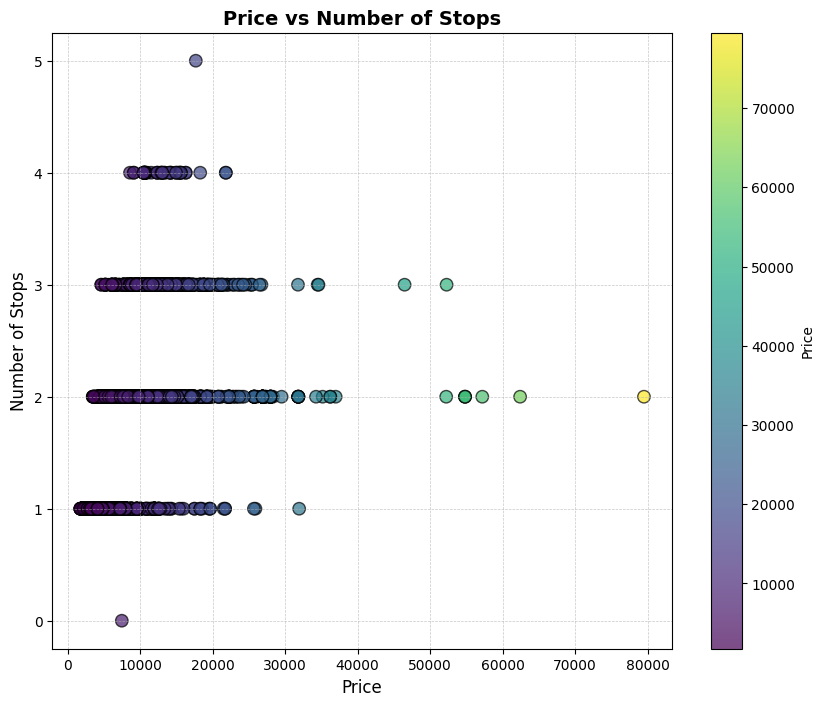

In [27]:
# Create a scatter plot with customized aesthetics
plt.figure(figsize=(10, 8))

# Use a color map to represent the data more beautifully
plt.scatter(data['Price'], data['Number_of_Stops'], s=80, alpha=0.7, c=data['Price'], cmap='viridis', edgecolors='black')

# Add a color bar to indicate the price scale
plt.colorbar(label='Price')

# Customize plot title and labels
plt.title('Price vs Number of Stops', fontsize=14, fontweight='bold')
plt.xlabel('Price', fontsize=12)
plt.ylabel('Number of Stops', fontsize=12)

# Add grid lines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
# Show the plot
plt.show()


Distribution of Flights Across Airlines

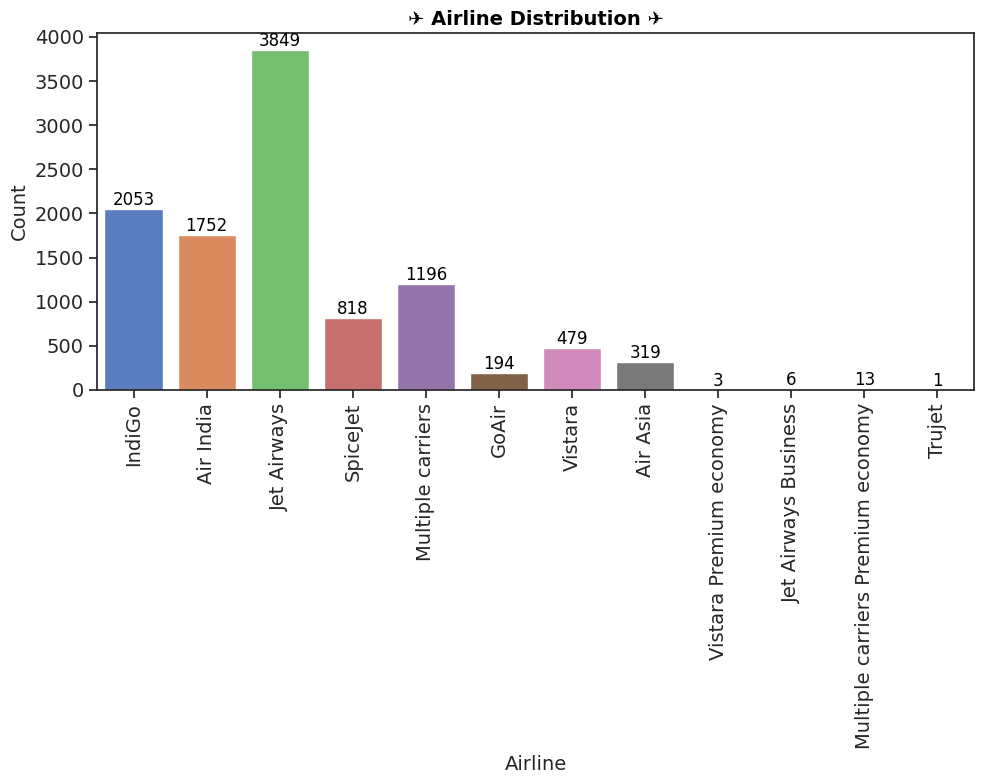

In [28]:
# Set a nice style
sns.set(style="ticks")

# Create the countplot with a color palette
plt.figure(figsize=(10, 8))
ax = sns.countplot(x="Airline", data=data, hue="Airline", palette="muted", legend=False)

# Title and labels with styling
plt.title("✈️ Airline Distribution ✈️", fontweight="bold", fontsize=14, color="black")
plt.xlabel("Airline", fontsize=14)
plt.ylabel("Count", fontsize=14)

# Rotate x-tick labels for better readability
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)


# Add value labels on bars
for bar in ax.patches:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 1,  # adjust +1 as needed
            f'{int(height)}', ha='center', va='bottom', fontsize=12, color='black',)

# Show the plot
plt.tight_layout()
plt.show()


Visualizing how ticket fares vary across different airlines over the journey dates



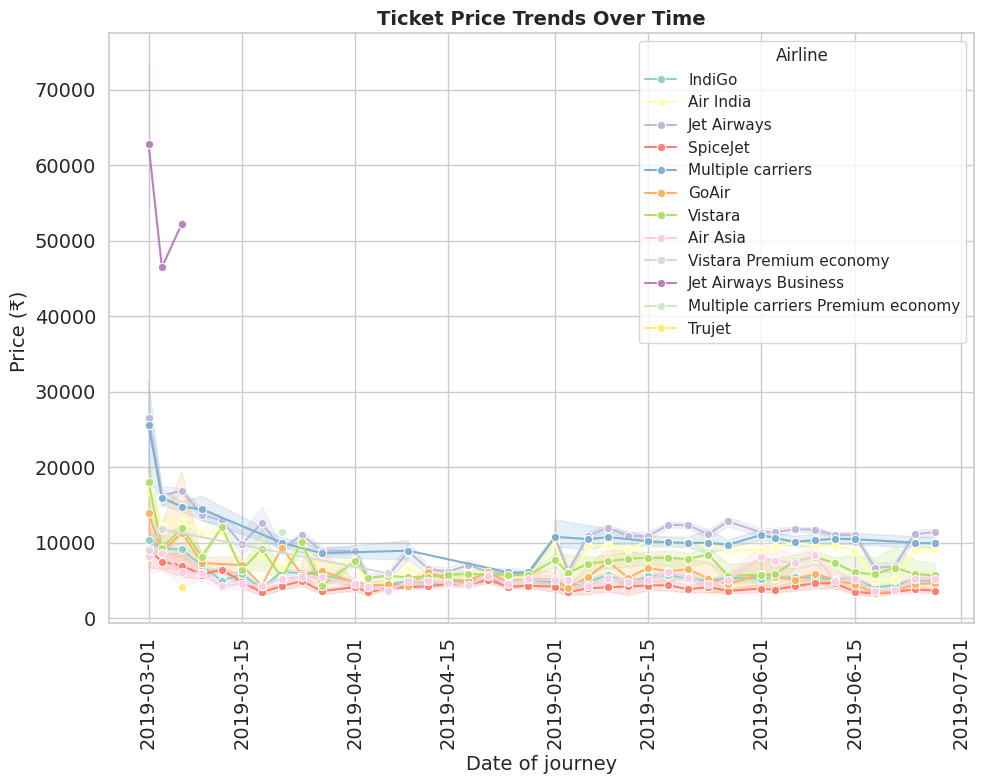

In [29]:
# Set Seaborn style
sns.set(style="whitegrid")

# Create the line plot
plt.figure(figsize=(10, 8))
sns.lineplot(x="Date_of_Journey", y="Price", data=data, hue="Airline", marker="o", palette="Set3") # Changed x to "Date_of_Journey" and y to "Price"

# Add title and labels
plt.title("Ticket Price Trends Over Time", fontsize=14, fontweight="bold")
plt.xlabel("Date of journey", fontsize=14)
plt.ylabel("Price (₹) ", fontsize=14)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
# Show the plot
plt.tight_layout()
plt.show()


The distribution of bookings as the departure date approaches.

Days_Until_Departure
10    214
11    214
12    214
13    214
14    214
15    214
16    214
17    214
18    214
19    214
20    214
21    214
22    214
23    214
24    214
25    214
26    214
27    214
28    214
29    214
30    214
31    214
32    214
33    214
34    214
35    214
36    214
37    214
38    214
39    214
40    214
41    214
42    214
43    213
44    213
45    213
46    213
47    213
48    213
49    213
50    213
51    213
52    213
53    213
54    213
55    213
56    213
57    213
58    213
59    213
Name: count, dtype: int64


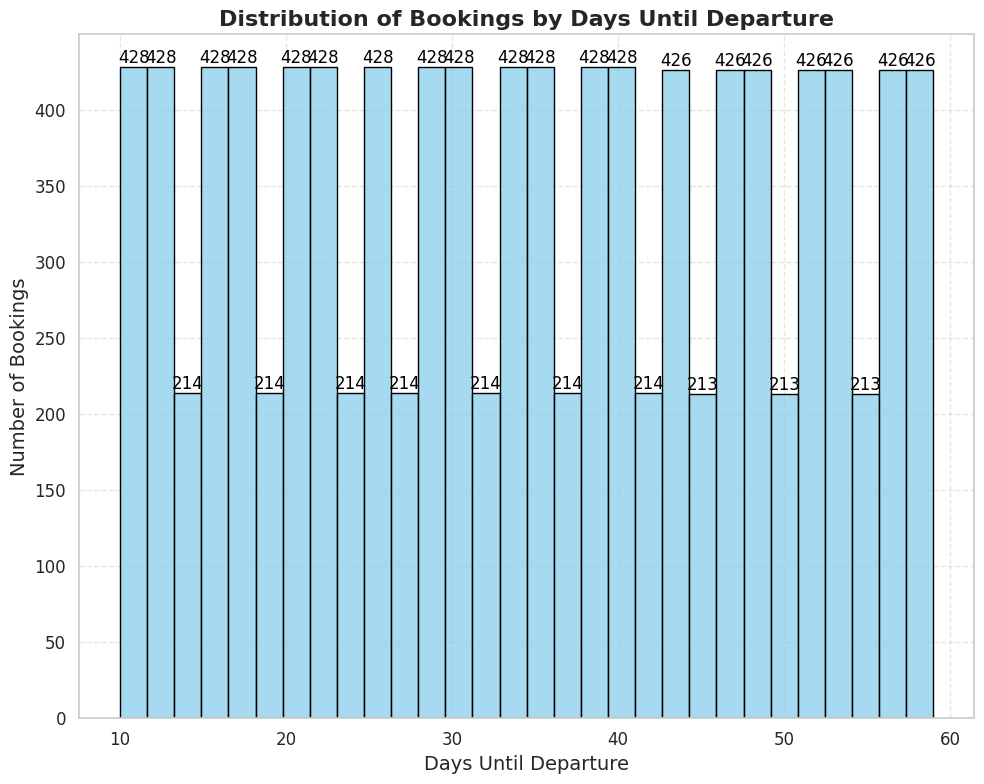

In [30]:
# Assuming 'Days_Until_Departure' is in your data, we first calculate the frequency of each unique value
days_count = data['Days_Until_Departure'].value_counts().sort_index()
print(days_count)
import seaborn as sns
import matplotlib.pyplot as plt

# Set a clean style
sns.set(style="whitegrid")

# Plot the histogram
plt.figure(figsize=(10,8))
ax = sns.histplot(
    data=data,
    x='Days_Until_Departure',
    bins=30,
    color='skyblue',
    edgecolor='black'
)

# Titles and labels
plt.title('Distribution of Bookings by Days Until Departure', fontsize=16, fontweight='bold')
plt.xlabel('Days Until Departure', fontsize=14)
plt.ylabel('Number of Bookings', fontsize=14)

# Annotate each bar with the count value
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}',  # Display the count as an integer
        (p.get_x() + p.get_width() / 2, p.get_height()),  # Position of the text
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=12,  # Font size of annotations
        color='black'  # Color of the text
    )

# Formatting
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Should keep this graph in last it would be better

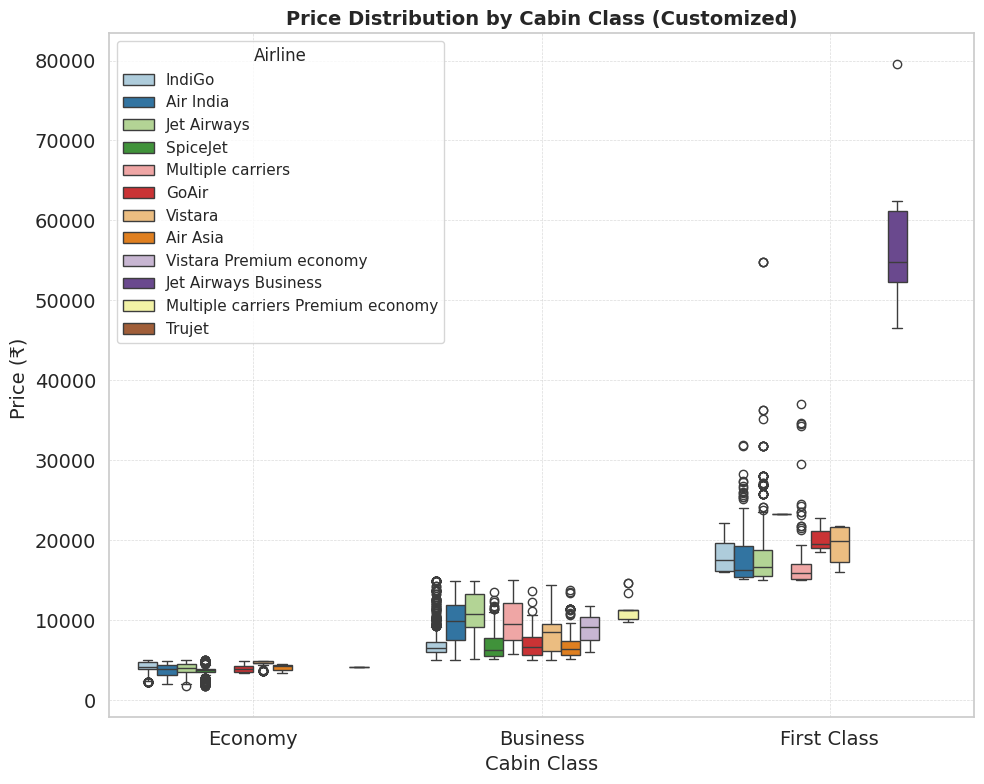

In [31]:
# Set style
sns.set(style="whitegrid")

# Create a boxplot with hue for another variable (e.g., Flight Type)
plt.figure(figsize=(10, 8))
#sns.boxplot(x="Cabin_Class", y="Price", data=data, palette=["#3498db", "#e74c3c"], hue="Airline")
sns.boxplot(x="Cabin_Class", y="Price", data=data, palette="Paired",hue="Airline")

# Customize title, labels, and grid lines
plt.title("Price Distribution by Cabin Class (Customized)", fontsize=14, fontweight='bold')
plt.xlabel("Cabin Class", fontsize=14)
plt.ylabel("Price (₹) ", fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# Show the plot
plt.tight_layout()
plt.show()


 Visualisation of Price Distribution by Cabin Class

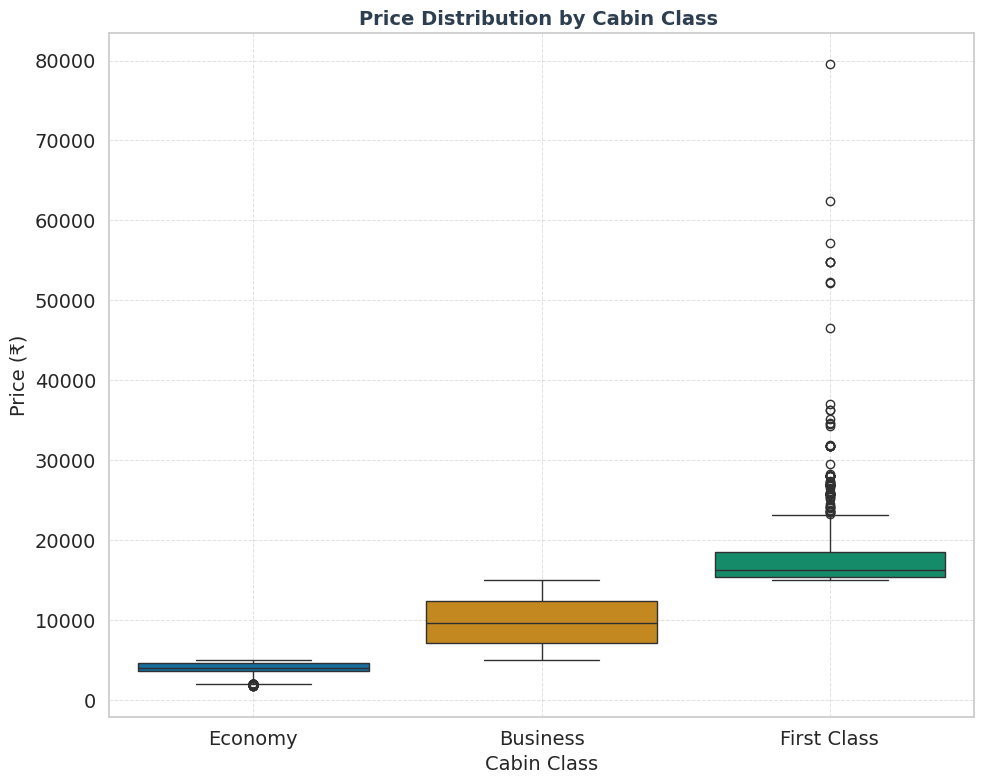

In [32]:
# Set style for a clean, modern look
sns.set(style="whitegrid")

# Create the boxplot for Cabin Class vs Price
plt.figure(figsize=(10, 8))
sns.boxplot(x="Cabin_Class", y="Price", data=data, palette="colorblind",hue ="Cabin_Class" )

# Customize title, labels, and grid lines
plt.title("Price Distribution by Cabin Class ", fontsize=14, fontweight='bold', color="#2c3e50")
plt.xlabel("Cabin Class", fontsize=14)
plt.ylabel("Price (₹)", fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.6)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# Show the plot
plt.tight_layout()
plt.show()


  Visualisation of Airline Price Distribution

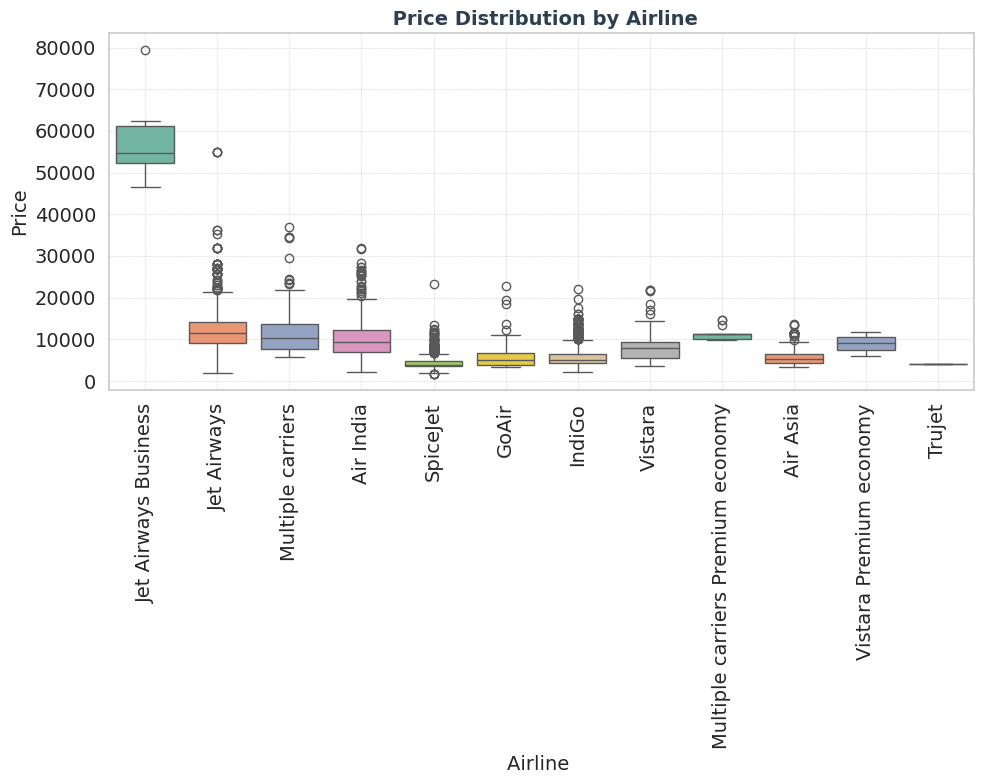

In [33]:
# Set style for a clean, modern look
sns.set(style="whitegrid")

# Create the boxplot
plt.figure(figsize=(10, 8))
sns.boxplot(x="Airline", y="Price", data=data.sort_values('Price', ascending=False), hue="Airline",palette="Set2")

# Customize title, labels, and grid lines with emojis
plt.title(" Price Distribution by Airline", fontsize=14, fontweight='bold', color="#2c3e50")
plt.xlabel("Airline ", fontsize=14)
plt.ylabel("Price", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation = 90, fontsize=14)
plt.yticks(fontsize=14)
# Add grid lines for readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


Visualizing the Correlation Matrix of Flight Fare Dataset

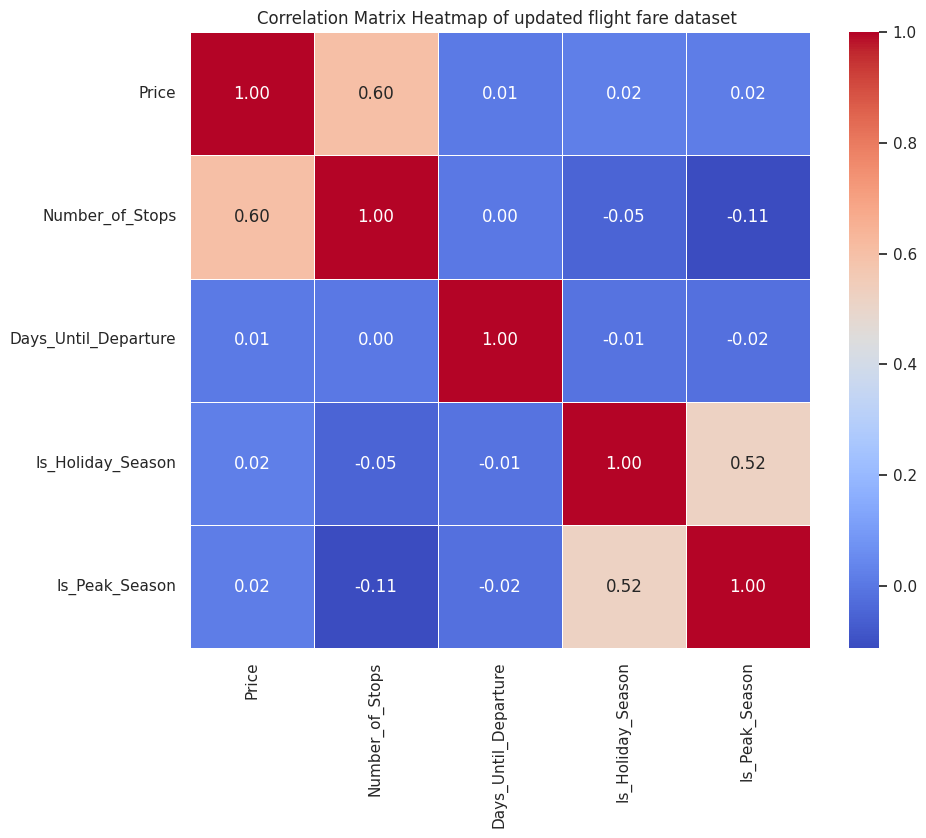

In [34]:
# Load the dataset
file_path = "Updated_Flight_Fare_Data.xlsx"  # Update with your correct file path
data = pd.read_excel(file_path)

# Compute the correlation matrix
corr_matrix = data.corr(numeric_only=True)  # Ensures only numeric columns are considered

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap of updated flight fare dataset ")
plt.show()


In [35]:
 #Top 10 used Routes and visualize using barplot

most_used_routes = data["Route"].value_counts().sort_values(ascending = False)[:10]
most_used_routes

Route
DEL → BOM → COK          2376
BLR → DEL                1552
CCU → BOM → BLR           979
CCU → BLR                 724
BOM → HYD                 621
CCU → DEL → BLR           565
BLR → BOM → DEL           402
MAA → CCU                 381
DEL → HYD → COK           326
DEL → JAI → BOM → COK     240
Name: count, dtype: int64

visualisation of top 10 most used routes using bar plot

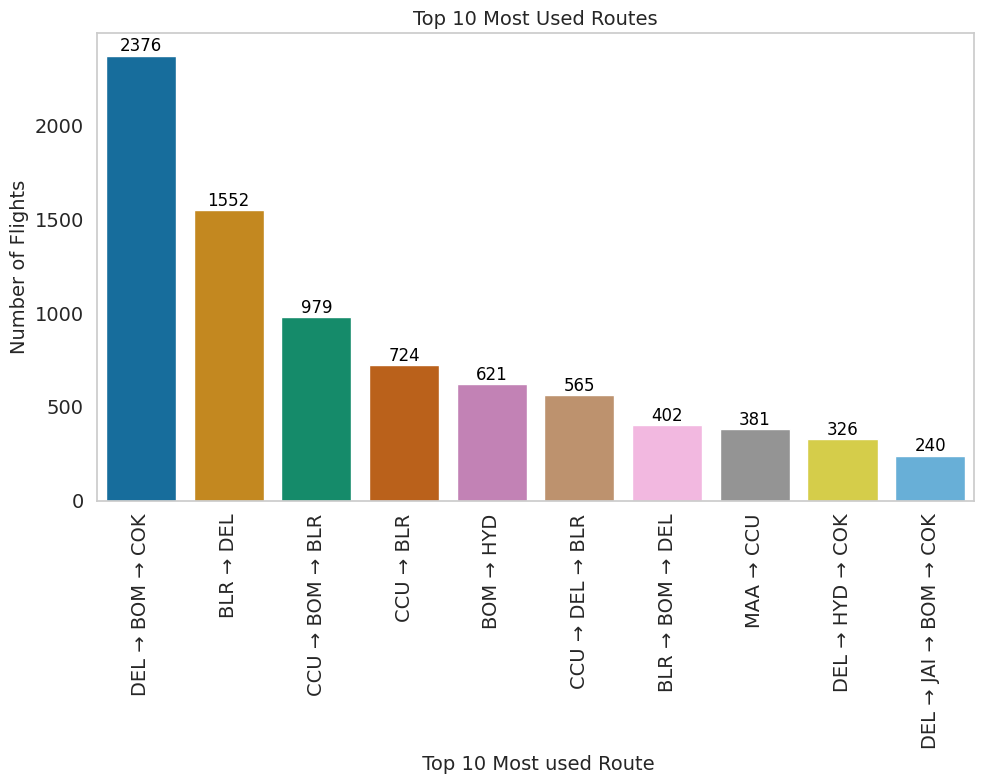

In [36]:
plt.figure(figsize=(10,8))
ax=sns.barplot(x=most_used_routes.index, y=most_used_routes.values, palette="colorblind",hue=most_used_routes.index)
# Customize the title and labels
plt.title('Top 10 Most Used Routes', fontsize=14)
plt.xlabel(' Top 10 Most used Route', fontsize=14)
plt.ylabel('Number of Flights', fontsize=14)

plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
# Add value labels on bars
for bar in ax.patches:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 1,  # adjust +1 as needed
            f'{int(height)}', ha='center', va='bottom', fontsize=12, color='black',)
plt.grid(False)
# Show the plot
plt.tight_layout()
plt.show()

Feature Engineering after updating the data set

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Airline               10683 non-null  object        
 1   Date_of_Journey       10683 non-null  datetime64[ns]
 2   Source                10683 non-null  object        
 3   Destination           10683 non-null  object        
 4   Route                 10682 non-null  object        
 5   Dep_Time              10683 non-null  object        
 6   Arrival_Time          10683 non-null  object        
 7   Duration              10683 non-null  object        
 8   Total_Stops           10682 non-null  object        
 9   Additional_Info       10683 non-null  object        
 10  Price                 10683 non-null  int64         
 11  Cabin_Class           10683 non-null  object        
 12  Number_of_Stops       10683 non-null  int64         
 13  Flight_Layover  

In [38]:
#checking missing values
data.isnull().sum()

Airline                 0
Date_of_Journey         0
Source                  0
Destination             0
Route                   1
Dep_Time                0
Arrival_Time            0
Duration                0
Total_Stops             1
Additional_Info         0
Price                   0
Cabin_Class             0
Number_of_Stops         0
Flight_Layover          0
Booking_Date            0
Days_Until_Departure    0
Is_Holiday_Season       0
Is_Peak_Season          0
dtype: int64

In [39]:
## Display the data types of each column in the dataset
data.dtypes

Airline                         object
Date_of_Journey         datetime64[ns]
Source                          object
Destination                     object
Route                           object
Dep_Time                        object
Arrival_Time                    object
Duration                        object
Total_Stops                     object
Additional_Info                 object
Price                            int64
Cabin_Class                     object
Number_of_Stops                  int64
Flight_Layover                  object
Booking_Date            datetime64[ns]
Days_Until_Departure             int64
Is_Holiday_Season                int64
Is_Peak_Season                   int64
dtype: object

In [40]:
# Retrieve the unique values present in the 'Date_of_Journey' column
data["Date_of_Journey"].unique()

<DatetimeArray>
['2019-03-24 00:00:00', '2019-05-01 00:00:00', '2019-06-09 00:00:00',
 '2019-05-12 00:00:00', '2019-03-01 00:00:00', '2019-06-24 00:00:00',
 '2019-03-12 00:00:00', '2019-05-27 00:00:00', '2019-06-01 00:00:00',
 '2019-04-18 00:00:00', '2019-05-09 00:00:00', '2019-04-24 00:00:00',
 '2019-03-03 00:00:00', '2019-04-15 00:00:00', '2019-06-12 00:00:00',
 '2019-03-06 00:00:00', '2019-03-21 00:00:00', '2019-04-03 00:00:00',
 '2019-05-06 00:00:00', '2019-05-15 00:00:00', '2019-06-18 00:00:00',
 '2019-06-15 00:00:00', '2019-04-06 00:00:00', '2019-05-18 00:00:00',
 '2019-06-27 00:00:00', '2019-05-21 00:00:00', '2019-06-03 00:00:00',
 '2019-03-15 00:00:00', '2019-05-03 00:00:00', '2019-03-09 00:00:00',
 '2019-06-06 00:00:00', '2019-05-24 00:00:00', '2019-04-01 00:00:00',
 '2019-04-21 00:00:00', '2019-06-21 00:00:00', '2019-03-27 00:00:00',
 '2019-03-18 00:00:00', '2019-04-12 00:00:00', '2019-04-09 00:00:00',
 '2019-04-27 00:00:00']
Length: 40, dtype: datetime64[ns]

In [41]:
# Ensure 'Date of Journey' is in datetime format
data['Date_of_Journey'] = pd.to_datetime(data['Date_of_Journey'])
#errors='coerce')

# Extract date components
data['Day'] = data['Date_of_Journey'].dt.day
data['Month'] = data['Date_of_Journey'].dt.month
data['Year'] = data['Date_of_Journey'].dt.year

print(data.head(2))
#droping the column is optional
data.drop("Date_of_Journey", inplace=True, axis=1)



     Airline Date_of_Journey    Source Destination                  Route  \
0     IndiGo      2019-03-24  Banglore   New Delhi              BLR → DEL   
1  Air India      2019-05-01   Kolkata    Banglore  CCU → IXR → BBI → BLR   

  Dep_Time  Arrival_Time Duration Total_Stops Additional_Info  ...  \
0    22:20  01:10 22 Mar   2h 50m    non-stop         No info  ...   
1    05:50         13:15   7h 25m     2 stops         No info  ...   

   Cabin_Class Number_of_Stops  Flight_Layover Booking_Date  \
0      Economy               1       1 Stop(s)   2019-03-14   
1     Business               3       3 Stop(s)   2019-04-20   

  Days_Until_Departure  Is_Holiday_Season  Is_Peak_Season  Day  Month  Year  
0                   10                  0               1   24      3  2019  
1                   11                  1               1    1      5  2019  

[2 rows x 21 columns]


 Function to extract hour and minute components from a datetime column


In [42]:
def extract_hour_min(data,col):
  # Ensure the column is in datetime format before using .dt accessor
    data[col] = pd.to_datetime(data[col])
    data[col+"_hour"]=data[col].dt.hour
    data[col+"_minute"]=data[col].dt.minute
    return data.head(2)

In [43]:
# Apply the extract_hour_min function to extract hour and minute from the 'Dep_Time' column

extract_hour_min(data, "Dep_Time")

<ipython-input-42-e34e52dae364>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[col] = pd.to_datetime(data[col])


Airline    Source Destination                  Route            Dep_Time  \
0     IndiGo  Banglore   New Delhi              BLR → DEL 2025-04-28 22:20:00   
1  Air India   Kolkata    Banglore  CCU → IXR → BBI → BLR 2025-04-28 05:50:00   

   Arrival_Time Duration Total_Stops Additional_Info  Price  ...  \
0  01:10 22 Mar   2h 50m    non-stop         No info   3897  ...   
1         13:15   7h 25m     2 stops         No info   7662  ...   

  Flight_Layover  Booking_Date Days_Until_Departure Is_Holiday_Season  \
0      1 Stop(s)    2019-03-14                   10                 0   
1      3 Stop(s)    2019-04-20                   11                 1   

   Is_Peak_Season  Day  Month  Year  Dep_Time_hour  Dep_Time_minute  
0               1   24      3  2019             22               20  
1               1    1      5  2019              5               50  

[2 rows x 22 columns]

In [44]:
# Extract hour and minute from the 'Arrival_Time' column using the extract_hour_min function

extract_hour_min(data, "Arrival_Time")

<ipython-input-42-e34e52dae364>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[col] = pd.to_datetime(data[col])


Airline    Source Destination                  Route            Dep_Time  \
0     IndiGo  Banglore   New Delhi              BLR → DEL 2025-04-28 22:20:00   
1  Air India   Kolkata    Banglore  CCU → IXR → BBI → BLR 2025-04-28 05:50:00   

         Arrival_Time Duration Total_Stops Additional_Info  Price  ...  \
0 2025-03-22 01:10:00   2h 50m    non-stop         No info   3897  ...   
1 2025-04-28 13:15:00   7h 25m     2 stops         No info   7662  ...   

  Days_Until_Departure  Is_Holiday_Season Is_Peak_Season Day  Month  Year  \
0                   10                  0              1  24      3  2019   
1                   11                  1              1   1      5  2019   

   Dep_Time_hour  Dep_Time_minute  Arrival_Time_hour  Arrival_Time_minute  
0             22               20                  1                   10  
1              5               50                 13                   15  

[2 rows x 24 columns]

now we can drop the dep_time and arrival time as well

In [45]:
cols_to_drop =['Arrival_Time', 'Dep_Time']
data.drop(cols_to_drop, axis=1, inplace=True)

In [46]:
data.head(2)

Airline    Source Destination                  Route Duration  \
0     IndiGo  Banglore   New Delhi              BLR → DEL   2h 50m   
1  Air India   Kolkata    Banglore  CCU → IXR → BBI → BLR   7h 25m   

  Total_Stops Additional_Info  Price Cabin_Class  Number_of_Stops  ...  \
0    non-stop         No info   3897     Economy                1  ...   
1     2 stops         No info   7662    Business                3  ...   

  Days_Until_Departure Is_Holiday_Season  Is_Peak_Season  Day  Month  Year  \
0                   10                 0               1   24      3  2019   
1                   11                 1               1    1      5  2019   

   Dep_Time_hour  Dep_Time_minute  Arrival_Time_hour  Arrival_Time_minute  
0             22               20                  1                   10  
1              5               50                 13                   15  

[2 rows x 22 columns]

In [47]:
data["Booking_Date"].unique()

<DatetimeArray>
['2019-03-14 00:00:00', '2019-04-20 00:00:00', '2019-05-28 00:00:00',
 '2019-04-29 00:00:00', '2019-02-15 00:00:00', '2019-06-09 00:00:00',
 '2019-02-24 00:00:00', '2019-02-12 00:00:00', '2019-02-22 00:00:00',
 '2019-05-08 00:00:00',
 ...
 '2019-01-11 00:00:00', '2019-06-07 00:00:00', '2019-06-08 00:00:00',
 '2019-06-14 00:00:00', '2019-01-06 00:00:00', '2019-06-06 00:00:00',
 '2019-01-01 00:00:00', '2019-01-02 00:00:00', '2019-06-13 00:00:00',
 '2019-06-17 00:00:00']
Length: 168, dtype: datetime64[ns]

Function to categorize flight departure time into different time slots based on the hour


In [48]:
def flight_dep_time(x):
    if (x > 4) and (x <= 8):
        return "Early Morning"
    elif (x > 8) and (x <= 12):
        return "Morning"
    elif (x > 12) and (x <= 16):
        return "Noon"
    elif (x > 16) and (x <= 20):
        return "Evening"
    elif (x > 20) and (x <= 24):
        return "Night"
    else:
        return "late night"  # Corrected indentation

Number of Flights Departing at Different Times

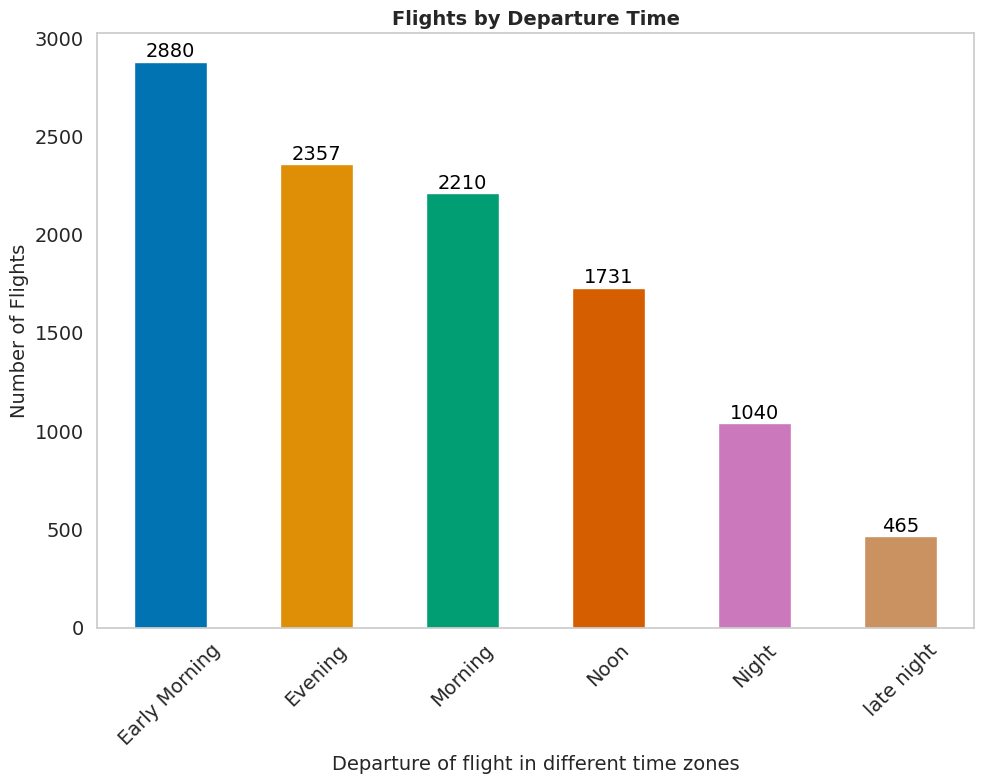

In [49]:
# Create the bar plot
plt.figure(figsize=(10, 8))
ax=data['Dep_Time_hour'].apply(flight_dep_time).value_counts().plot(kind="bar", color=sns.color_palette("colorblind")) # Pass the color palette using 'color'

# Add value labels on top of bars
for bar in ax.patches:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 1,
            f'{int(height)}', ha='center', va='bottom', fontsize=14, color='black')

# Add axis labels and title
plt.xlabel("Departure of flight in different time zones", fontsize=14,)
plt.ylabel("Number of Flights", fontsize=14)
plt.title("Flights by Departure Time", fontsize=14, fontweight="bold")
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
ax.grid(False)

plt.tight_layout()
plt.show()


In [50]:
data.head(2)

Airline    Source Destination                  Route Duration  \
0     IndiGo  Banglore   New Delhi              BLR → DEL   2h 50m   
1  Air India   Kolkata    Banglore  CCU → IXR → BBI → BLR   7h 25m   

  Total_Stops Additional_Info  Price Cabin_Class  Number_of_Stops  ...  \
0    non-stop         No info   3897     Economy                1  ...   
1     2 stops         No info   7662    Business                3  ...   

  Days_Until_Departure Is_Holiday_Season  Is_Peak_Season  Day  Month  Year  \
0                   10                 0               1   24      3  2019   
1                   11                 1               1    1      5  2019   

   Dep_Time_hour  Dep_Time_minute  Arrival_Time_hour  Arrival_Time_minute  
0             22               20                  1                   10  
1              5               50                 13                   15  

[2 rows x 22 columns]

function adds '0h' if hours are missing, and '0m' if minutes are missing in the duration.


In [51]:
def prepocess_duration(x):
  if 'h' not in x:
      x = '0h'+' '+ x
  elif 'm' not in x:
      x = x + ' '+'0m'
  return x

In [52]:
# Applies the 'preprocess_duration' function to ensure the 'Duration' column has both hours and minutes.

data['Duration']=data['Duration'].apply(prepocess_duration)

In [53]:
data['Duration']

0        2h 50m
1        7h 25m
2        19h 0m
3        5h 25m
4        4h 45m
          ...  
10678    2h 30m
10679    2h 35m
10680     3h 0m
10681    2h 40m
10682    8h 20m
Name: Duration, Length: 10683, dtype: object

 Extracts hours and minutes from the 'Duration' column, removes 'h' and 'm',
 and converts them into integers

In [54]:
data['Duration_hours'] = data['Duration'].str.split(' ').str[0].str.replace('h', '').astype(int)
data['Duration_minutes'] = data['Duration'].str.split(' ').str[1].str.replace('m', '').astype(int)

In [55]:
data.head(2)

Airline    Source Destination                  Route Duration  \
0     IndiGo  Banglore   New Delhi              BLR → DEL   2h 50m   
1  Air India   Kolkata    Banglore  CCU → IXR → BBI → BLR   7h 25m   

  Total_Stops Additional_Info  Price Cabin_Class  Number_of_Stops  ...  \
0    non-stop         No info   3897     Economy                1  ...   
1     2 stops         No info   7662    Business                3  ...   

  Is_Peak_Season Day  Month  Year  Dep_Time_hour  Dep_Time_minute  \
0              1  24      3  2019             22               20   
1              1   1      5  2019              5               50   

   Arrival_Time_hour  Arrival_Time_minute  Duration_hours  Duration_minutes  
0                  1                   10               2                50  
1                 13                   15               7                25  

[2 rows x 24 columns]

In [56]:
# Converts the 'Duration' column into total minutes by multiplying hours by 60 and adding minutes.

data['Duration_total_mins']=data['Duration'].str.replace('h',"*60").str.replace(' ','+').str.replace('m' ,"*1").apply(eval)

Visualizing the Relationship Between Flight Duration, Price, and Total Stops

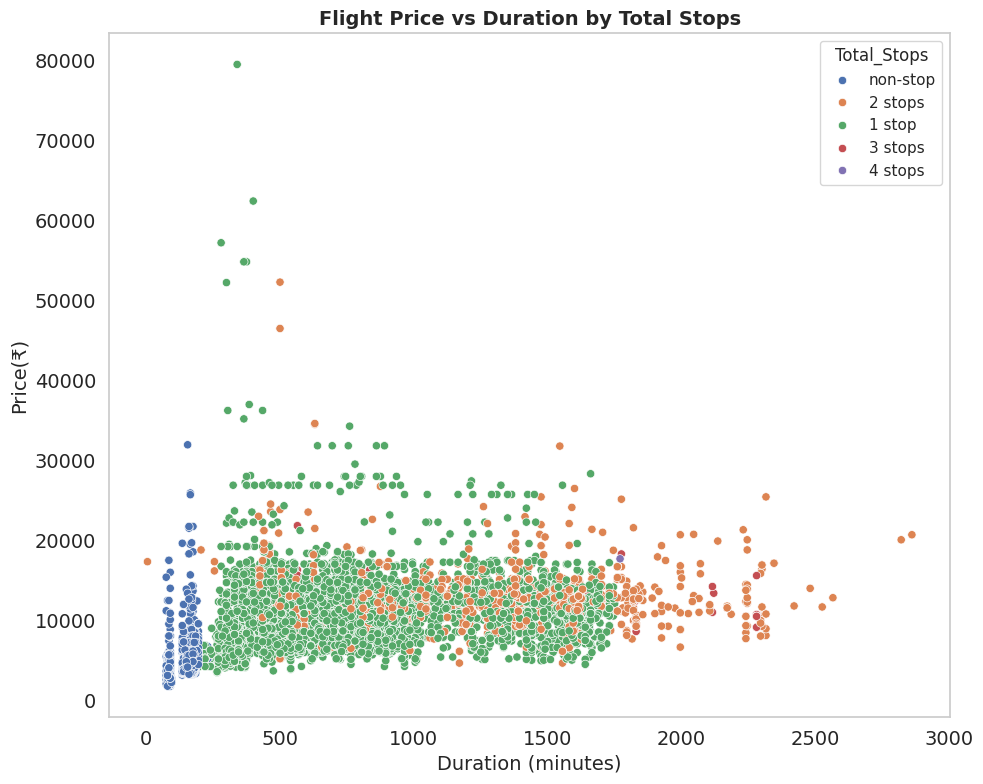

In [57]:
plt.figure(figsize=(10,8))
# Create scatter plot
sns.scatterplot(x="Duration_total_mins", y="Price", hue="Total_Stops", data=data)
plt.title("Flight Price vs Duration by Total Stops", fontsize=14, fontweight="bold")
# Add axis labels
plt.xlabel("Duration (minutes)", fontsize=14)
plt.ylabel("Price(₹)", fontsize=14)
# Remove grid lines
plt.grid(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


Analyzing the Linear Relationship Between Flight Duration and Ticket Price

<Figure size 1000x800 with 0 Axes>

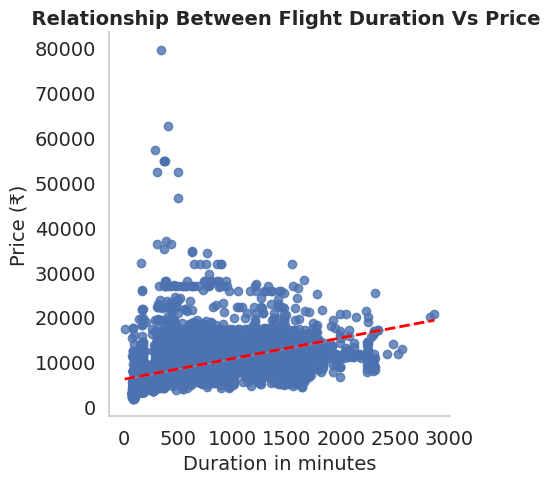

In [58]:
plt.figure(figsize=(10,8))
# Create a linear model plot (scatter plot with regression line)
sns.lmplot(x="Duration_total_mins", y="Price", data=data,
           line_kws={'color': 'red', 'linewidth': 2, 'linestyle': '--'})  # Customize the regression line

plt.title("  Relationship Between Flight Duration Vs Price", fontsize=14,fontweight="bold")
plt.xlabel("Duration in minutes", fontsize=14)
plt.ylabel("Price (₹)", fontsize=14)

# Remove grid lines
plt.grid(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# Show the plot
plt.tight_layout()
plt.show()


Extracting Categorical Columns from a Dataset

In [59]:
#Loops through all columns in the DataFrame and appends the names of categorical columns (dtype 'object') to the Categorical_Column list.
Categorical_Column = []
for col in data.columns:
    if data[col].dtype == 'object':
        Categorical_Column.append(col)


In [60]:
print(Categorical_Column)


['Airline', 'Source', 'Destination', 'Route', 'Duration', 'Total_Stops', 'Additional_Info', 'Cabin_Class', 'Flight_Layover']


 Extracting numerical columns from the dataset

In [61]:
Numerical_column = []
for col in data.columns:
    if data[col].dtype != 'object':
        Numerical_column.append(col)
        from sklearn.preprocessing import LabelEncoder





In [62]:
print(Numerical_column)


['Price', 'Number_of_Stops', 'Booking_Date', 'Days_Until_Departure', 'Is_Holiday_Season', 'Is_Peak_Season', 'Day', 'Month', 'Year', 'Dep_Time_hour', 'Dep_Time_minute', 'Arrival_Time_hour', 'Arrival_Time_minute', 'Duration_hours', 'Duration_minutes', 'Duration_total_mins']


In [63]:
#to obtain unique values present in the 'Source' column
data['Source'].unique()

array(['Banglore', 'Kolkata', 'Delhi', 'Chennai', 'Mumbai'], dtype=object)

In [64]:
# Iterate over each unique value in the 'Source' column to create dummy variables
for sub_category in data['Source'].unique():
#Create a new column for each unique 'Source' category, where 1 indicates the presence of the category, 0 otherwise
  data[f'Source_{sub_category}'] = (data['Source'] == sub_category).astype(int)


In [65]:
data.head(2)

Airline    Source Destination                  Route Duration  \
0     IndiGo  Banglore   New Delhi              BLR → DEL   2h 50m   
1  Air India   Kolkata    Banglore  CCU → IXR → BBI → BLR   7h 25m   

  Total_Stops Additional_Info  Price Cabin_Class  Number_of_Stops  ...  \
0    non-stop         No info   3897     Economy                1  ...   
1     2 stops         No info   7662    Business                3  ...   

  Arrival_Time_hour Arrival_Time_minute  Duration_hours  Duration_minutes  \
0                 1                  10               2                50   
1                13                  15               7                25   

   Duration_total_mins  Source_Banglore  Source_Kolkata  Source_Delhi  \
0                  170                1               0             0   
1                  445                0               1             0   

   Source_Chennai  Source_Mumbai  
0               0              0  
1               0              0  

[2 rows x 30 columns]

In [66]:
# calculate the average price for each airline and sort the results in ascending order
airlines = data.groupby(['Airline'])['Price'].mean().sort_values()
airlines

Airline
Trujet                                4140.000000
SpiceJet                              4338.284841
Air Asia                              5590.260188
IndiGo                                5673.682903
GoAir                                 5861.056701
Vistara                               7796.348643
Vistara Premium economy               8962.333333
Air India                             9611.210616
Multiple carriers                    10902.678094
Multiple carriers Premium economy    11418.846154
Jet Airways                          11643.923357
Jet Airways Business                 58358.666667
Name: Price, dtype: float64

In [67]:
#reseting the index values based on the average price
airlines = data.groupby(['Airline'])['Price'].mean().sort_values().index
airlines

Index(['Trujet', 'SpiceJet', 'Air Asia', 'IndiGo', 'GoAir', 'Vistara',
       'Vistara Premium economy', 'Air India', 'Multiple carriers',
       'Multiple carriers Premium economy', 'Jet Airways',
       'Jet Airways Business'],
      dtype='object', name='Airline')

In [68]:
# Create a dictionary with airlines and their corresponding indices
dict_airlines={key:index for index, key in enumerate(airlines,0)}
dict_airlines

{'Trujet': 0,
 'SpiceJet': 1,
 'Air Asia': 2,
 'IndiGo': 3,
 'GoAir': 4,
 'Vistara': 5,
 'Vistara Premium economy': 6,
 'Air India': 7,
 'Multiple carriers': 8,
 'Multiple carriers Premium economy': 9,
 'Jet Airways': 10,
 'Jet Airways Business': 11}

In [69]:
## Replace airline names with their corresponding indices from the dictionary
data['Airline']=data['Airline'].map(dict_airlines)
data['Airline']

0         3
1         7
2        10
3         3
4         3
         ..
10678     2
10679     7
10680    10
10681     5
10682     7
Name: Airline, Length: 10683, dtype: int64

In [70]:
data.head(2)

Airline    Source Destination                  Route Duration Total_Stops  \
0        3  Banglore   New Delhi              BLR → DEL   2h 50m    non-stop   
1        7   Kolkata    Banglore  CCU → IXR → BBI → BLR   7h 25m     2 stops   

  Additional_Info  Price Cabin_Class  Number_of_Stops  ... Arrival_Time_hour  \
0         No info   3897     Economy                1  ...                 1   
1         No info   7662    Business                3  ...                13   

  Arrival_Time_minute  Duration_hours  Duration_minutes  Duration_total_mins  \
0                  10               2                50                  170   
1                  15               7                25                  445   

   Source_Banglore  Source_Kolkata  Source_Delhi  Source_Chennai  \
0                1               0             0               0   
1                0               1             0               0   

   Source_Mumbai  
0              0  
1              0  

[2 rows x 30 columns]

In [71]:
#Get the unique values in the 'Destination' column
data['Destination'].unique()

array(['New Delhi', 'Banglore', 'Cochin', 'Kolkata', 'Delhi', 'Hyderabad'],
      dtype=object)

In [72]:
# Replace 'New Delhi' with 'Delhi' in the 'Destination' column and then get the unique values
data['Destination'] = data['Destination'].replace('New Delhi', 'Delhi')
data['Destination'].unique()

array(['Delhi', 'Banglore', 'Cochin', 'Kolkata', 'Hyderabad'],
      dtype=object)

In [73]:
# Get the destinations sorted by their average price
destination = data.groupby(['Destination'])['Price'].mean().sort_values().index
destination

Index(['Kolkata', 'Hyderabad', 'Delhi', 'Banglore', 'Cochin'], dtype='object', name='Destination')

In [74]:
#Create a dictionary with destinations as keys and their indices as values
dict_destination={key:index for index, key in enumerate(destination,0)}
dict_destination

{'Kolkata': 0, 'Hyderabad': 1, 'Delhi': 2, 'Banglore': 3, 'Cochin': 4}

In [75]:
## Replace airline names with their corresponding indices from the dictionary
data['Destination']=data['Destination'].map(dict_destination)
data['Destination']

0        2
1        3
2        4
3        3
4        2
        ..
10678    3
10679    3
10680    2
10681    2
10682    4
Name: Destination, Length: 10683, dtype: int64

In [76]:
data.head(2)

Airline    Source  Destination                  Route Duration Total_Stops  \
0        3  Banglore            2              BLR → DEL   2h 50m    non-stop   
1        7   Kolkata            3  CCU → IXR → BBI → BLR   7h 25m     2 stops   

  Additional_Info  Price Cabin_Class  Number_of_Stops  ... Arrival_Time_hour  \
0         No info   3897     Economy                1  ...                 1   
1         No info   7662    Business                3  ...                13   

  Arrival_Time_minute  Duration_hours  Duration_minutes  Duration_total_mins  \
0                  10               2                50                  170   
1                  15               7                25                  445   

   Source_Banglore  Source_Kolkata  Source_Delhi  Source_Chennai  \
0                1               0             0               0   
1                0               1             0               0   

   Source_Mumbai  
0              0  
1              0  

[2 rows x 30 columns]

In [77]:
#Retrieve the unique values present in the 'Total_Stops' column
data['Total_Stops'].unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', nan, '4 stops'],
      dtype=object)

 Create a dictionary mapping unique 'Total_Stops' values to numerical indices for standardization


In [78]:
Total_Stops=data['Total_Stops'].unique()

# Create the dictionary using the unique values
dict_Total_Stops = {key: index for index, key in enumerate(Total_Stops, 0)}
dict_Total_Stops
data.head(2)


Airline    Source  Destination                  Route Duration Total_Stops  \
0        3  Banglore            2              BLR → DEL   2h 50m    non-stop   
1        7   Kolkata            3  CCU → IXR → BBI → BLR   7h 25m     2 stops   

  Additional_Info  Price Cabin_Class  Number_of_Stops  ... Arrival_Time_hour  \
0         No info   3897     Economy                1  ...                 1   
1         No info   7662    Business                3  ...                13   

  Arrival_Time_minute  Duration_hours  Duration_minutes  Duration_total_mins  \
0                  10               2                50                  170   
1                  15               7                25                  445   

   Source_Banglore  Source_Kolkata  Source_Delhi  Source_Chennai  \
0                1               0             0               0   
1                0               1             0               0   

   Source_Mumbai  
0              0  
1              0  

[2 rows x 30 columns]

In [79]:
data.head(1)

Airline    Source  Destination      Route Duration Total_Stops  \
0        3  Banglore            2  BLR → DEL   2h 50m    non-stop   

  Additional_Info  Price Cabin_Class  Number_of_Stops  ... Arrival_Time_hour  \
0         No info   3897     Economy                1  ...                 1   

  Arrival_Time_minute  Duration_hours  Duration_minutes  Duration_total_mins  \
0                  10               2                50                  170   

   Source_Banglore  Source_Kolkata  Source_Delhi  Source_Chennai  \
0                1               0             0               0   

   Source_Mumbai  
0              0  

[1 rows x 30 columns]

In [80]:
#extract unique values
data['Additional_Info'].unique()

array(['No info', 'In-flight meal not included',
       'No check-in baggage included', '1 Short layover', 'No Info',
       '1 Long layover', 'Change airports', 'Business class',
       'Red-eye flight', '2 Long layover'], dtype=object)

In [81]:
data['Additional_Info'].value_counts()

Additional_Info
No info                         8345
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: count, dtype: int64

Calculate the percentage distribution of each unique value in the 'Additional_Info' column


In [82]:
data['Additional_Info'].value_counts()/len(data)*100

Additional_Info
No info                         78.114762
In-flight meal not included     18.552841
No check-in baggage included     2.995413
1 Long layover                   0.177853
Change airports                  0.065525
Business class                   0.037443
No Info                          0.028082
1 Short layover                  0.009361
Red-eye flight                   0.009361
2 Long layover                   0.009361
Name: count, dtype: float64

In [83]:
data.head(1)

Airline    Source  Destination      Route Duration Total_Stops  \
0        3  Banglore            2  BLR → DEL   2h 50m    non-stop   

  Additional_Info  Price Cabin_Class  Number_of_Stops  ... Arrival_Time_hour  \
0         No info   3897     Economy                1  ...                 1   

  Arrival_Time_minute  Duration_hours  Duration_minutes  Duration_total_mins  \
0                  10               2                50                  170   

   Source_Banglore  Source_Kolkata  Source_Delhi  Source_Chennai  \
0                1               0             0               0   

   Source_Mumbai  
0              0  

[1 rows x 30 columns]

Remove the 'Additional_Info', 'Source', 'Route', and 'Duration' columns from the dataset to clean the data


In [84]:
data.drop(columns=['Additional_Info','Source','Route','Duration','Flight_Layover'],axis=1,inplace=True)
data.head(2)

Airline  Destination Total_Stops  Price Cabin_Class  Number_of_Stops  \
0        3            2    non-stop   3897     Economy                1   
1        7            3     2 stops   7662    Business                3   

  Booking_Date  Days_Until_Departure  Is_Holiday_Season  Is_Peak_Season  ...  \
0   2019-03-14                    10                  0               1  ...   
1   2019-04-20                    11                  1               1  ...   

   Arrival_Time_hour  Arrival_Time_minute  Duration_hours  Duration_minutes  \
0                  1                   10               2                50   
1                 13                   15               7                25   

   Duration_total_mins  Source_Banglore  Source_Kolkata  Source_Delhi  \
0                  170                1               0             0   
1                  445                0               1             0   

   Source_Chennai  Source_Mumbai  
0               0              0  
1               0              0  

[2 rows x 25 columns]

cabin class


In [85]:
data['Cabin_Class'].unique()

array(['Economy', 'Business', 'First Class'], dtype=object)

In [86]:
# Get the unique values of the 'Cabin_Class' column from the DataFrame
Cabin_Class = data['Cabin_Class'].unique()

# Create the dictionary using the unique values
dict_Cabin_Class = {key: index for index, key in enumerate(Cabin_Class, 0)}
dict_Cabin_Class



{'Economy': 0, 'Business': 1, 'First Class': 2}

Convert 'Cabin_Class' values to numerical values using the 'dict_Cabin_Class' mapping


In [87]:
data['Cabin_Class']=data['Cabin_Class'].map(dict_Cabin_Class)
data['Cabin_Class']

0        0
1        1
2        1
3        1
4        1
        ..
10678    0
10679    0
10680    1
10681    1
10682    1
Name: Cabin_Class, Length: 10683, dtype: int64

Create a dictionary to map 'Total_Stops' values to numbers


In [88]:
Total_Stops = data['Total_Stops'].unique()

# Create the dictionary using the unique values
dict_Total_Stops = {key: index for index, key in enumerate(Total_Stops, 0)}
dict_Total_Stops


{'non-stop': 0, '2 stops': 1, '1 stop': 2, '3 stops': 3, nan: 4, '4 stops': 5}

Map 'Total_Stops' values to numerical values using the 'dict_Total_Stops' dictionary


In [89]:
data['Total_Stops']=data['Total_Stops'].map(dict_Total_Stops)
data['Total_Stops']

0        0
1        1
2        1
3        2
4        2
        ..
10678    0
10679    0
10680    0
10681    0
10682    1
Name: Total_Stops, Length: 10683, dtype: int64

Set pandas option to display all columns in the DataFrame for better visibility


In [90]:
# Set pandas option to display all columns
pd.set_option('display.max_columns', None)

# Display the DataFrame
data


Airline  Destination  Total_Stops  Price  Cabin_Class  Number_of_Stops  \
0            3            2            0   3897            0                1   
1            7            3            1   7662            1                3   
2           10            4            1  13882            1                3   
3            3            3            2   6218            1                2   
4            3            2            2  13302            1                2   
...        ...          ...          ...    ...          ...              ...   
10678        2            3            0   4107            0                1   
10679        7            3            0   4145            0                1   
10680       10            2            0   7229            1                1   
10681        5            2            0  12648            1                1   
10682        7            4            1  11753            1                3   

      Booking_Date  Days_Until_Departure  Is_Holiday_Season  Is_Peak_Season  \
0       2019-03-14                    10                  0               1   
1       2019-04-20                    11                  1               1   
2       2019-05-28                    12                  0               0   
3       2019-04-29                    13                  1               1   
4       2019-02-15                    14                  1               1   
...            ...                   ...                ...             ...   
10678   2019-03-02                    38                  0               1   
10679   2019-03-19                    39                  0               1   
10680   2019-03-18                    40                  0               1   
10681   2019-01-19                    41                  1               1   
10682   2019-03-28                    42                  0               0   

       Day  Month  Year  Dep_Time_hour  Dep_Time_minute  Arrival_Time_hour  \
0       24      3  2019             22               20                  1   
1        1      5  2019              5               50                 13   
2        9      6  2019              9               25                  4   
3       12      5  2019             18                5                 23   
4        1      3  2019             16               50                 21   
...    ...    ...   ...            ...              ...                ...   
10678    9      4  2019             19               55                 22   
10679   27      4  2019             20               45                 23   
10680   27      4  2019              8               20                 11   
10681    1      3  2019             11               30                 14   
10682    9      5  2019             10               55                 19   

       Arrival_Time_minute  Duration_hours  Duration_minutes  \
0                       10               2                50   
1                       15               7                25   
2                       25              19                 0   
3                       30               5                25   
4                       35               4                45   
...                    ...             ...               ...   
10678                   25               2                30   
10679                   20               2                35   
10680                   20               3                 0   
10681                   10               2                40   
10682                   15               8                20   

       Duration_total_mins  Source_Banglore  Source_Kolkata  Source_Delhi  \
0                      170                1               0             0   
1                      445                0               1             0   
2                     1140                0               0             1   
3                      325                0               1            

Identifying Outliers in the 'Price' Column Using the IQR (Interquartile Range) Method


In [91]:
Q1 = data['Price'].quantile(0.25)
Q3 = data['Price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers of the price
outliers= data[(data['Price'] < lower_bound) | (data['Price'] > upper_bound)]
outliers

Airline  Destination  Total_Stops  Price  Cabin_Class  Number_of_Stops  \
123          7            4            2  27430            2                2   
396          8            4            2  36983            2                2   
486         10            2            2  26890            2                2   
510         10            2            2  26890            2                2   
597          7            1            1  25139            2                3   
...        ...          ...          ...    ...          ...              ...   
10353       10            1            1  24210            2                3   
10364       11            2            2  57209            2                2   
10383       10            2            2  26890            2                2   
10439       10            2            2  31825            2                2   
10511        7            2            1  26480            2                3   

      Booking_Date  Days_Until_Departure  Is_Holiday_Season  Is_Peak_Season  \
123     2019-01-27                    33                  1               1   
396     2019-01-04                    56                  1               1   
486     2019-01-14                    46                  1               1   
510     2019-02-09                    20                  1               1   
597     2019-01-08                    57                  0               1   
...            ...                   ...                ...             ...   
10353   2019-02-21                    13                  0               1   
10364   2019-02-05                    24                  1               1   
10383   2019-01-17                    43                  1               1   
10439   2019-01-11                    49                  1               1   
10511   2019-02-08                    21                  1               1   

       Day  Month  Year  Dep_Time_hour  Dep_Time_minute  Arrival_Time_hour  \
123      1      3  2019             23                0                 19   
396      1      3  2019             12               50                 19   
486      1      3  2019              8               55                 15   
510      1      3  2019              7                0                 12   
597      6      3  2019              9               40                 15   
...    ...    ...   ...            ...              ...                ...   
10353    6      3  2019             19               50                 16   
10364    1      3  2019              9               45                 14   
10383    1      3  2019              7                0                  5   
10439    1      3  2019             18               40                  9   
10511    1      3  2019              6               45                  9   

       Arrival_Time_minute  Duration_hours  Duration_minutes  \
123                     15              20                15   
396                     15               6                25   
486                     15               6                20   
510                     25               5                25   
597                     15              29                35   
...                    ...             ...               ...   
10353                   50              21                 0   
10364                   25               4                40   
10383                    5              22                 5   
10439                    0              14                20   
10511                   25              26                40   

       Duration_total_mins  Source_Banglore  Source_Kolkata  Source_Delhi  \
123                   1215                0               0             1   
396                    385                0               0             1   
486                    380                1               0             0   
510                    325                1               0            

In [92]:
# Print the lower bound value for detecting outliers in the 'Price' column

print(lower_bound)

-5367.0


In [93]:
# Print the upper bound value for detecting outliers in the 'Price' column

print(upper_bound)

23017.0


Visualizing Outliers in 'Price' Column Using Boxplot, Histogram, and Scatterplot


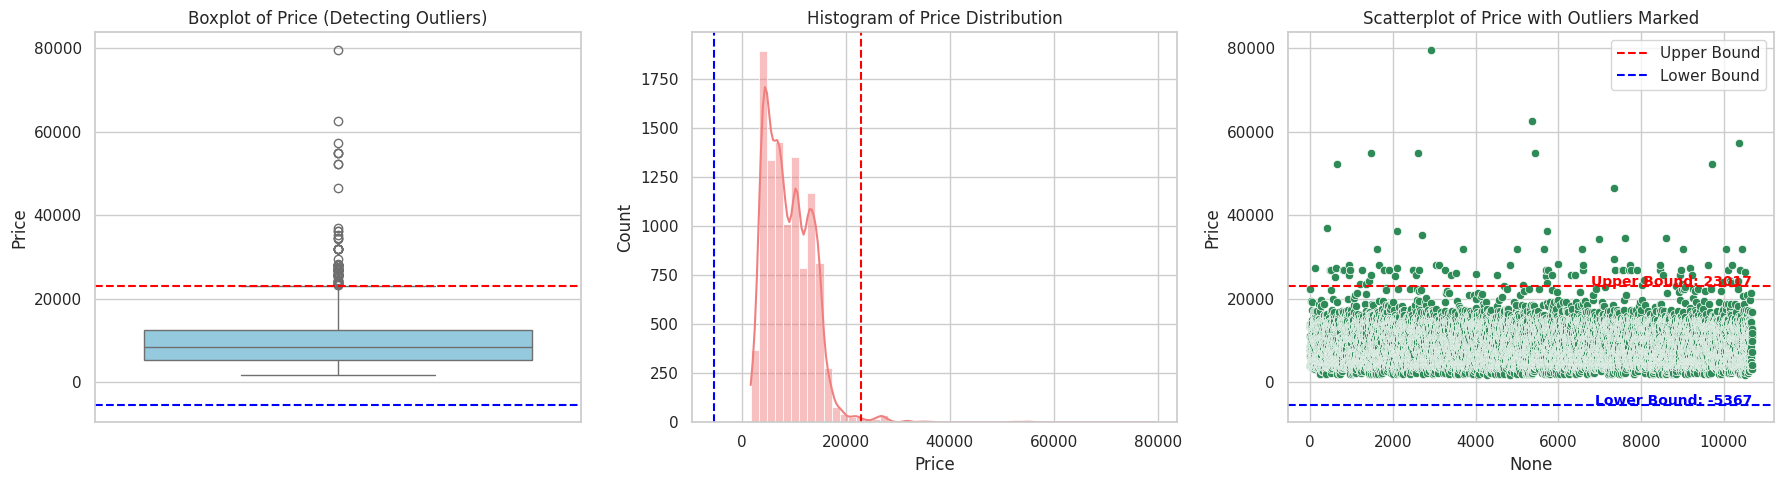

In [94]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Boxplot to show outliers
sns.boxplot(y=data['Price'], ax=axes[0], color='skyblue')
axes[0].set_title("Boxplot of Price (Detecting Outliers)")
axes[0].axhline(y=upper_bound, color='red', linestyle='dashed', label="Upper Bound")
axes[0].axhline(y=lower_bound, color='blue', linestyle='dashed', label="Lower Bound")


# Histogram to see price distribution
sns.histplot(data['Price'], bins=50, kde=True, ax=axes[1], color='lightcoral')
axes[1].set_title("Histogram of Price Distribution")
axes[1].axvline(x=upper_bound, color='red', linestyle='dashed', label="Upper Bound")
axes[1].axvline(x=lower_bound, color='blue', linestyle='dashed', label="Lower Bound")


# Scatterplot to identify outliers visually
sns.scatterplot(x=data.index, y=data['Price'], ax=axes[2], color='seagreen')
axes[2].axhline(y=upper_bound, color='red', linestyle='dashed', label="Upper Bound")
axes[2].axhline(y=lower_bound, color='blue', linestyle='dashed', label="Lower Bound")


# Annotate upper and lower bounds in scatterplot
axes[2].text(len(data) - 1, upper_bound, f'Upper Bound: {upper_bound:.0f}',
             color='red', ha='right', fontsize=10, fontweight='bold')
axes[2].text(len(data) - 1, lower_bound, f'Lower Bound: {lower_bound:.0f}',
             color='blue', ha='right', fontsize=10, fontweight='bold')
# Annotate outliers
for idx, row in outliers.iterrows():
    ax.annotate(f"{row['Price']:.0f}",
                     (idx, row['Price']),
                     textcoords="offset points",
                     xytext=(0,10), ha='center',
                     fontsize=9, color='red',
                     arrowprops=dict(arrowstyle="->", color='red'))
axes[2].legend()
axes[2].set_title("Scatterplot of Price with Outliers Marked")

plt.tight_layout()
plt.show()


In [95]:
# Calculate the number of outliers in the 'Price' column

len(outliers)

94

Top features by consedering all the feature

In [96]:
from sklearn.feature_selection import mutual_info_regression

In [97]:
X = data.drop(['Price'], axis=1)  # independent
y = data['Price']  # dependent
# Convert 'Booking_Date' to ordinal before calculating mutual information
X['Booking_Date'] = pd.to_datetime(X['Booking_Date'])  # Ensure it's datetime
X['Booking_Date'] = X['Booking_Date'].apply(lambda date: date.toordinal())

# Now calculate mutual information
imp = mutual_info_regression(X, y)
imp

array([1.32275267, 1.0643606 , 0.79191584, 0.77416102, 0.7931417 ,
       0.16814586, 0.01928099, 0.0918867 , 0.25966895, 0.37493577,
       0.6256053 , 0.        , 0.925581  , 0.75308286, 1.15331846,
       0.91303144, 1.12585103, 0.67640061, 1.77927034, 0.38175851,
       0.44764575, 0.53537168, 0.12780089, 0.19735663])

In [98]:
imp_df = pd.DataFrame(imp , index=X.columns)
imp_df

0
Airline               1.322753
Destination           1.064361
Total_Stops           0.791916
Cabin_Class           0.774161
Number_of_Stops       0.793142
Booking_Date          0.168146
Days_Until_Departure  0.019281
Is_Holiday_Season     0.091887
Is_Peak_Season        0.259669
Day                   0.374936
Month                 0.625605
Year                  0.000000
Dep_Time_hour         0.925581
Dep_Time_minute       0.753083
Arrival_Time_hour     1.153318
Arrival_Time_minute   0.913031
Duration_hours        1.125851
Duration_minutes      0.676401
Duration_total_mins   1.779270
Source_Banglore       0.381759
Source_Kolkata        0.447646
Source_Delhi          0.535372
Source_Chennai        0.127801
Source_Mumbai         0.197357

In [99]:
imp_df.columns = ['importance']
imp_df

importance
Airline                 1.322753
Destination             1.064361
Total_Stops             0.791916
Cabin_Class             0.774161
Number_of_Stops         0.793142
Booking_Date            0.168146
Days_Until_Departure    0.019281
Is_Holiday_Season       0.091887
Is_Peak_Season          0.259669
Day                     0.374936
Month                   0.625605
Year                    0.000000
Dep_Time_hour           0.925581
Dep_Time_minute         0.753083
Arrival_Time_hour       1.153318
Arrival_Time_minute     0.913031
Duration_hours          1.125851
Duration_minutes        0.676401
Duration_total_mins     1.779270
Source_Banglore         0.381759
Source_Kolkata          0.447646
Source_Delhi            0.535372
Source_Chennai          0.127801
Source_Mumbai           0.197357

In [100]:
imp_df.sort_values(by='importance' , ascending=False)

importance
Duration_total_mins     1.779270
Airline                 1.322753
Arrival_Time_hour       1.153318
Duration_hours          1.125851
Destination             1.064361
Dep_Time_hour           0.925581
Arrival_Time_minute     0.913031
Number_of_Stops         0.793142
Total_Stops             0.791916
Cabin_Class             0.774161
Dep_Time_minute         0.753083
Duration_minutes        0.676401
Month                   0.625605
Source_Delhi            0.535372
Source_Kolkata          0.447646
Source_Banglore         0.381759
Day                     0.374936
Is_Peak_Season          0.259669
Source_Mumbai           0.197357
Booking_Date            0.168146
Source_Chennai          0.127801
Is_Holiday_Season       0.091887
Days_Until_Departure    0.019281
Year                    0.000000

Feature Selection Using Mutual Information to Identify Top Predictive Features for 'Price'


🔹 Top Features based on Mutual Information:
 Duration_total_mins    1.773246
Airline                1.313196
Arrival_Time_hour      1.151014
Duration_hours         1.121270
Destination            1.067866
Dep_Time_hour          0.927254
Arrival_Time_minute    0.892074
Total_Stops            0.791878
Number_of_Stops        0.791178
Cabin_Class            0.781742
dtype: float64


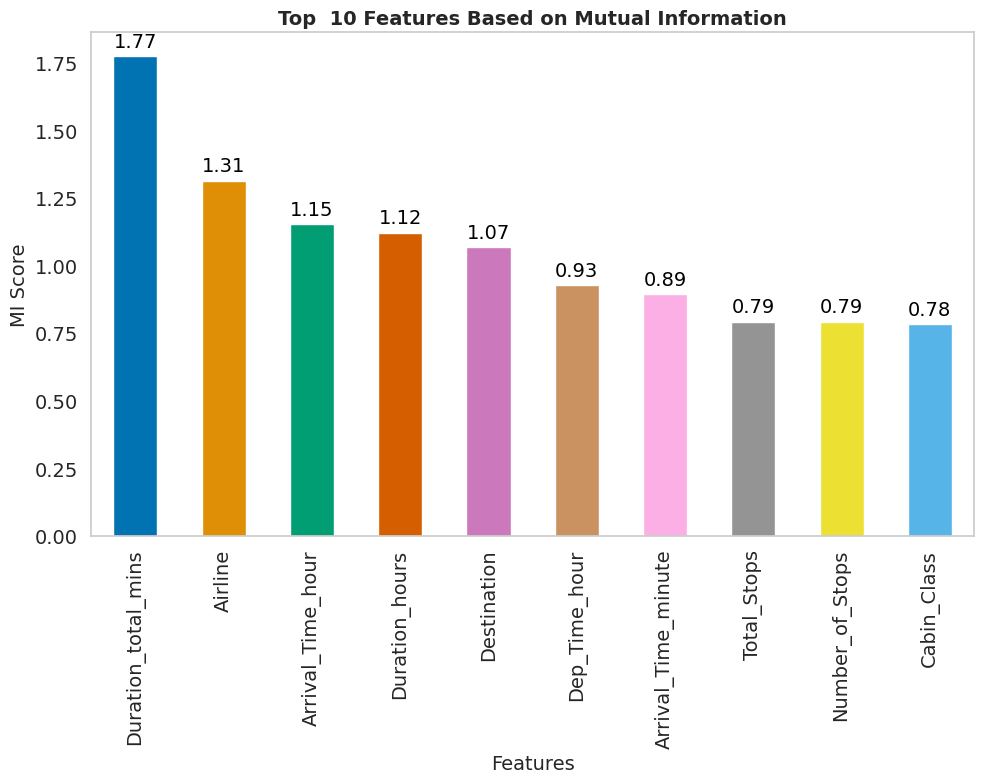

In [101]:
from sklearn.feature_selection import mutual_info_regression

# Assuming `data` is your DataFrame
X = data.drop(['Price'], axis=1)  # independent
y = data['Price']  # dependent

# Convert 'Booking_Date' to ordinal before calculating mutual information
X['Booking_Date'] = pd.to_datetime(X['Booking_Date'])  # Ensure it's datetime
X['Booking_Date'] = X['Booking_Date'].apply(lambda date: date.toordinal())  # Convert to ordinal representation

### 1. Mutual Information
mi = mutual_info_regression(X, y)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print("🔹 Top Features based on Mutual Information:\n", mi_series.head(10))

# Plot Mutual Information Scores
plt.figure(figsize=(10, 8))
colors = sns.color_palette("colorblind")  # Get the colorblind palette
ax = mi_series.head(10).plot(kind='bar', color=colors)  # Apply the colors


# Title and labels
plt.title("Top  10 Features Based on Mutual Information", fontsize=14,fontweight="bold")
plt.xlabel("Features", fontsize=14)
plt.ylabel("MI Score", fontsize=14)

# Annotate the values on top of the bars
for i, v in enumerate(mi_series.head(10)):
    ax.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=14, color='black')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)
# Show the plot
plt.tight_layout()
plt.show()


In [102]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression

Calculate and Visualize Mutual Information Between Features to Identify Relationships
[NO NEED JUST CHECK AT LAST]

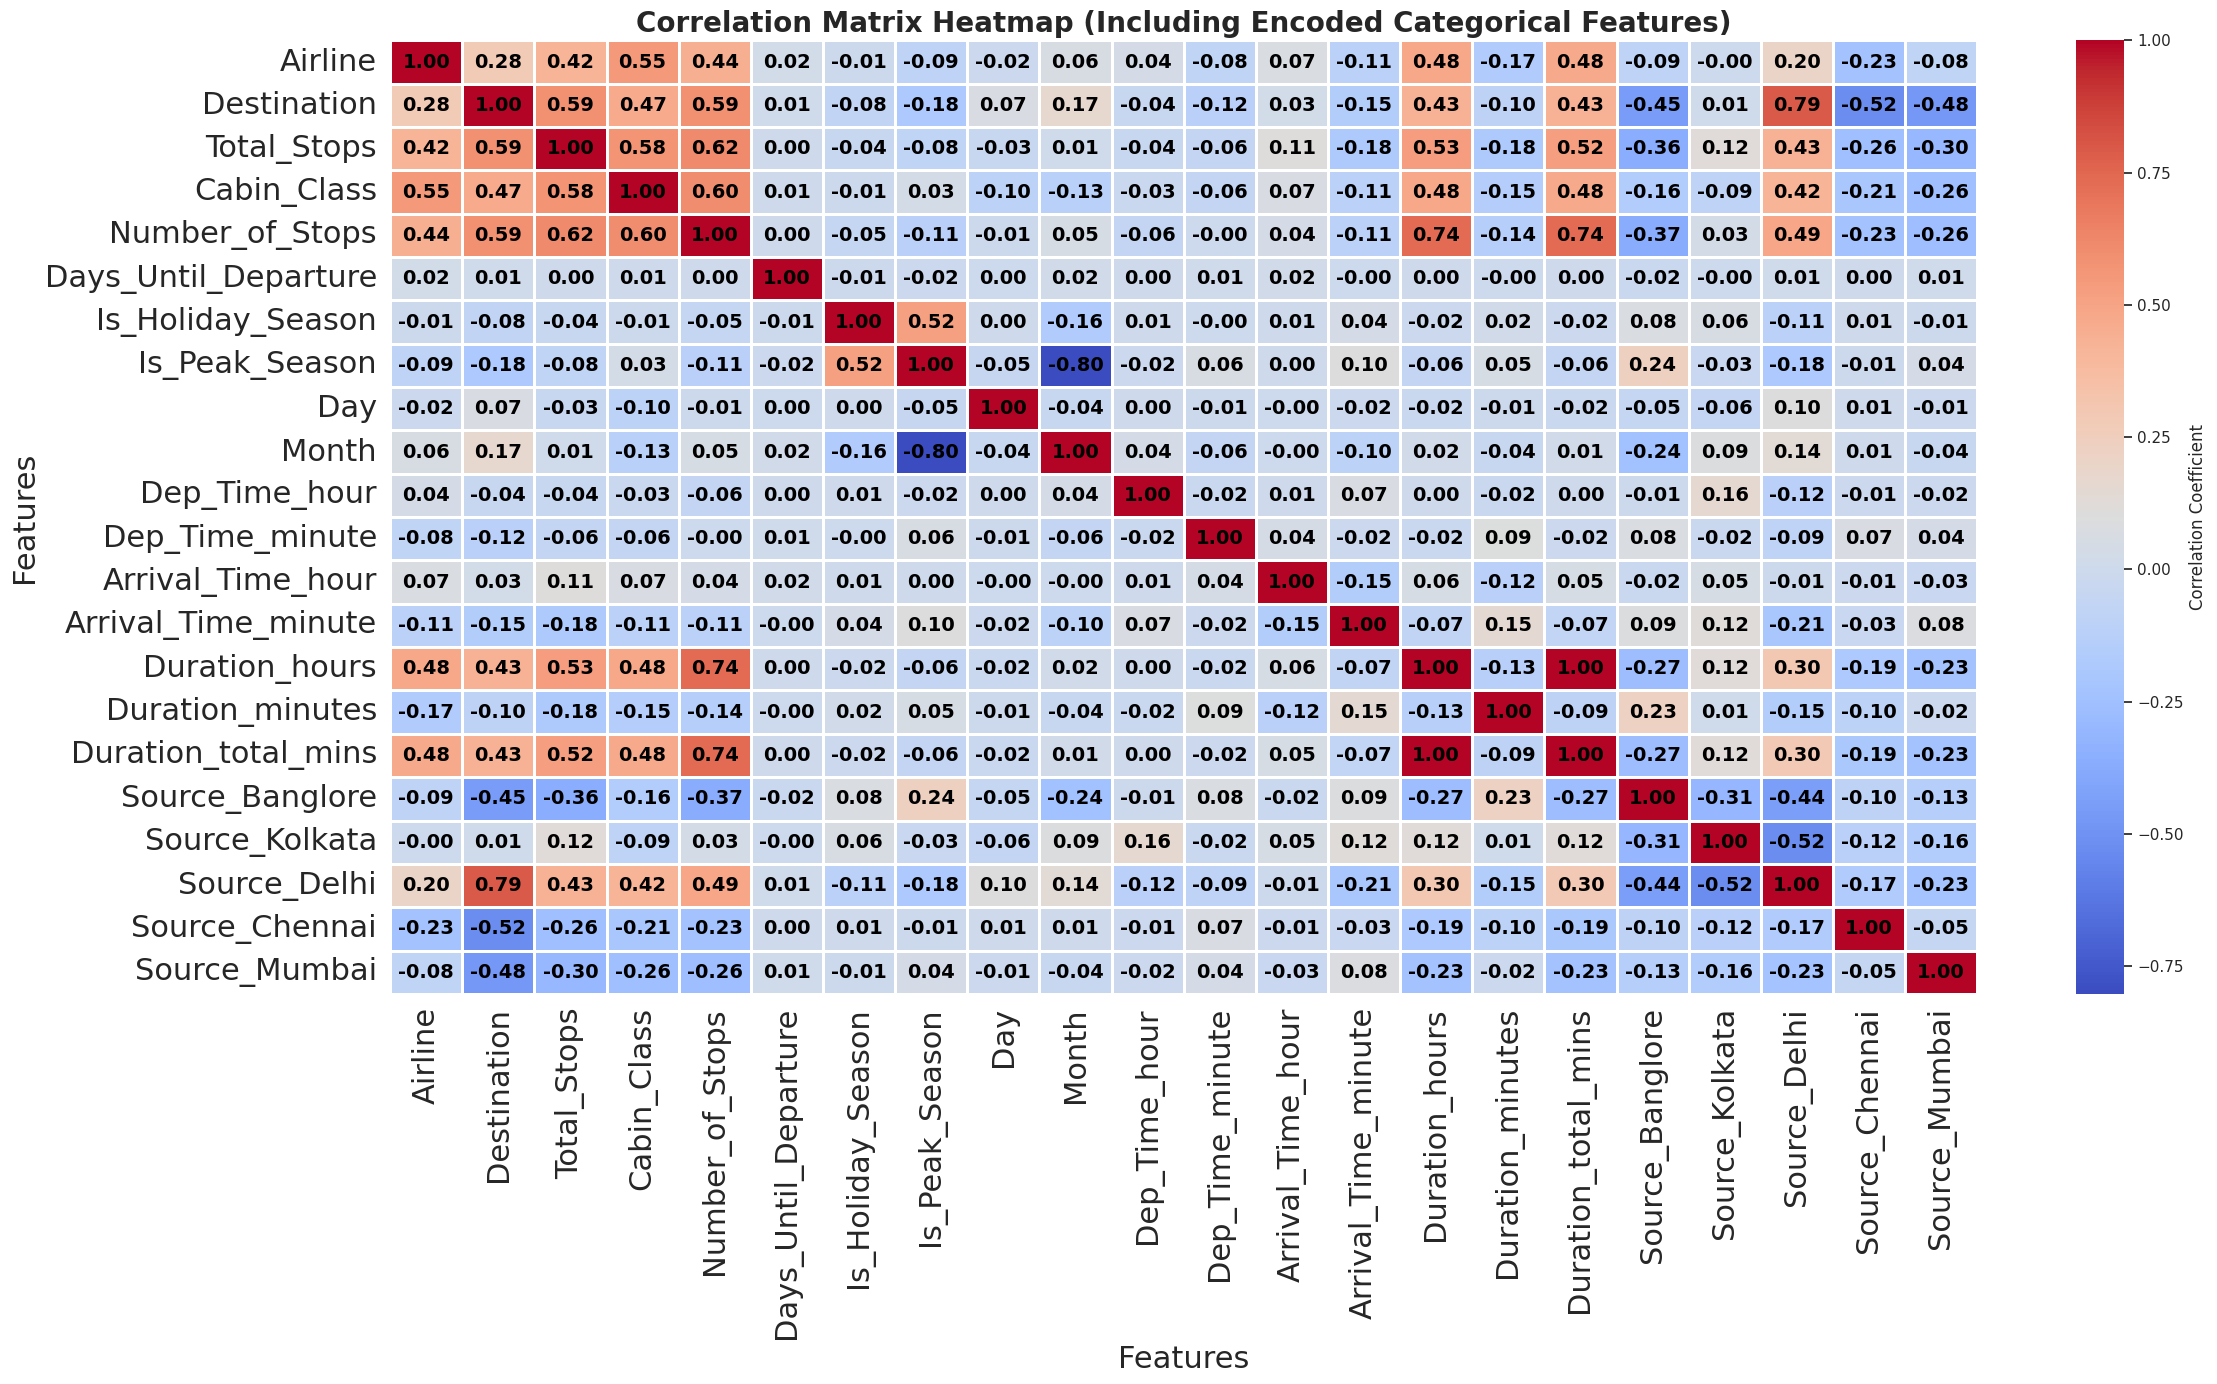

In [103]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset (assuming it's already in 'data' DataFrame)
X = data.drop(['Price','Year'], axis=1)  # Remove target variable (if applicable)

# Step 1: One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)  # One-hot encode categorical columns

# Step 2: Compute the correlation matrix (numerical columns only)
corr_matrix = X_encoded.corr(numeric_only=True)

# Step 3: Set up the aesthetics of the plot
plt.figure(figsize=(24, 14))  # Larger figure for better clarity

# Create the heatmap with clear visibility of values in the cells
heatmap = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=1,
                      linecolor='white', cbar_kws={'label': 'Correlation Coefficient'},
                      annot_kws={'size': 14, 'weight': 'bold', 'color': 'black'},
                      cbar=True)  # Show color bar

# Step 4: Adjust title and label fonts for better presentation
plt.title("Correlation Matrix Heatmap (Including Encoded Categorical Features)", fontsize=20, fontweight='bold')
plt.xlabel("Features", fontsize=22)
plt.ylabel("Features", fontsize=22)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

# Step 5: Adjust layout to avoid overlapping
plt.tight_layout()  # Adjust layout for better spacing

# Show the plot
plt.show()


Perform Recursive Feature Elimination (RFE) to Select Top Features and Visualize Rankings


🔹 RFE Feature Rankings (Lower is better):
 Cabin_Class              1
Number_of_Stops          1
Source_Delhi             1
Source_Mumbai            2
Is_Holiday_Season        3
Is_Peak_Season           4
Month                    5
Source_Chennai           6
Airline                  7
Days_Until_Departure     8
Booking_Date             9
Day                     10
Source_Banglore         11
Source_Kolkata          12
Destination             13
Total_Stops             14
Arrival_Time_hour       15
Dep_Time_hour           16
Dep_Time_minute         17
Arrival_Time_minute     18
Duration_minutes        19
Duration_total_mins     20
Duration_hours          21
dtype: int64

🔹 Top Features Selected by RFE:
 Index(['Cabin_Class', 'Number_of_Stops', 'Source_Delhi'], dtype='object')


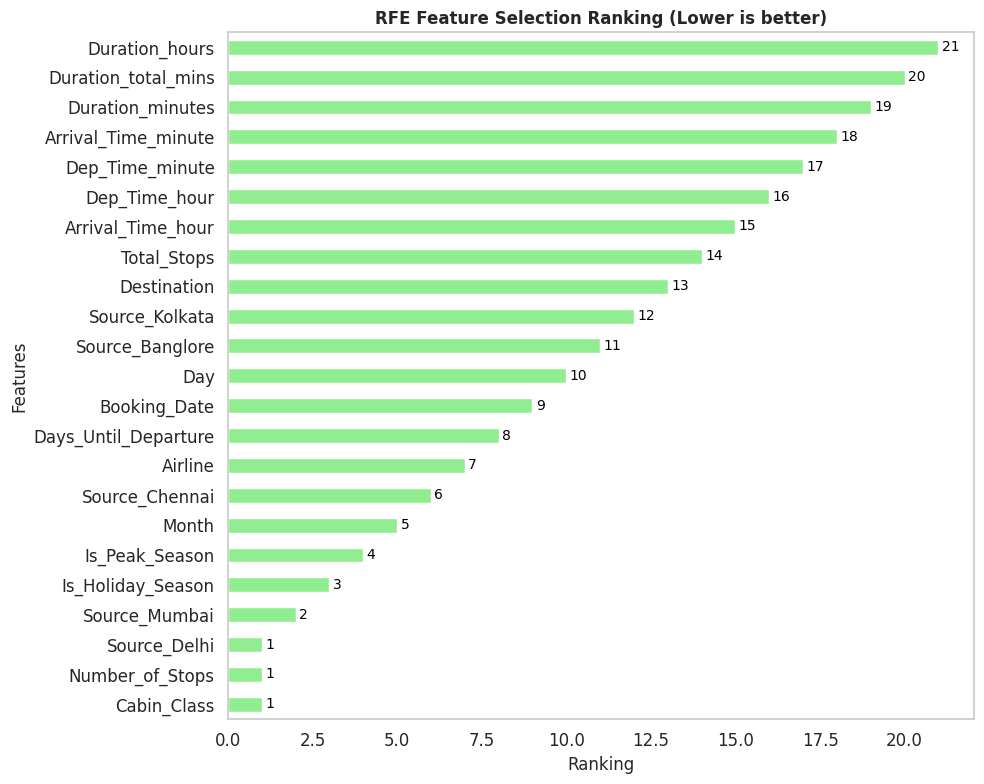

In [104]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd

# Initialize model
model = LinearRegression()

# Apply RFE to select top features
# Convert 'Booking_Date' to ordinal before fitting RFE
X['Booking_Date'] = pd.to_datetime(X['Booking_Date'])  # Ensure it's datetime
X['Booking_Date'] = X['Booking_Date'].apply(lambda date: date.toordinal())

rfe = RFE(model, n_features_to_select=3)
rfe.fit(X, y)

# Get selected features
selected_features_rfe = X.columns[rfe.support_]

# Get feature rankings
feature_rankings = pd.Series(rfe.ranking_, index=X.columns).sort_values()

# Print RFE rankings
print("🔹 RFE Feature Rankings (Lower is better):\n", feature_rankings)

# Print top selected features
print("\n🔹 Top Features Selected by RFE:\n", selected_features_rfe)

# Plot RFE Rankings
plt.figure(figsize=(10, 8))
feature_rankings.plot(kind='barh', color ="lightgreen")

# Annotate the values
for index, value in enumerate(feature_rankings):
    plt.text(value + 0.1, index, str(value), va='center', fontsize=10, color="black")  # Adjust text position as needed

# Title and label
plt.title("RFE Feature Selection Ranking (Lower is better)", fontsize=12, fontweight='bold')
plt.xlabel("Ranking", fontsize=12)
plt.ylabel("Features", fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Remove grid lines
plt.grid(False)

plt.tight_layout()
plt.show()


Feature Importance Evaluation Using Random Forest Model


Top  Features based on Random Forest Importance:
 Duration_total_mins     0.383908
Cabin_Class             0.258978
Airline                 0.100940
Duration_hours          0.048270
Day                     0.038614
Booking_Date            0.031285
Days_Until_Departure    0.018106
Arrival_Time_hour       0.015879
Dep_Time_hour           0.015783
Month                   0.015105
Destination             0.013578
Dep_Time_minute         0.012011
Number_of_Stops         0.011446
Duration_minutes        0.010257
Arrival_Time_minute     0.009890
Is_Holiday_Season       0.005869
Source_Kolkata          0.002882
Total_Stops             0.001979
Source_Banglore         0.001889
Source_Delhi            0.001524
Source_Mumbai           0.000709
Is_Peak_Season          0.000690
Source_Chennai          0.000409
Year                    0.000000
dtype: float64


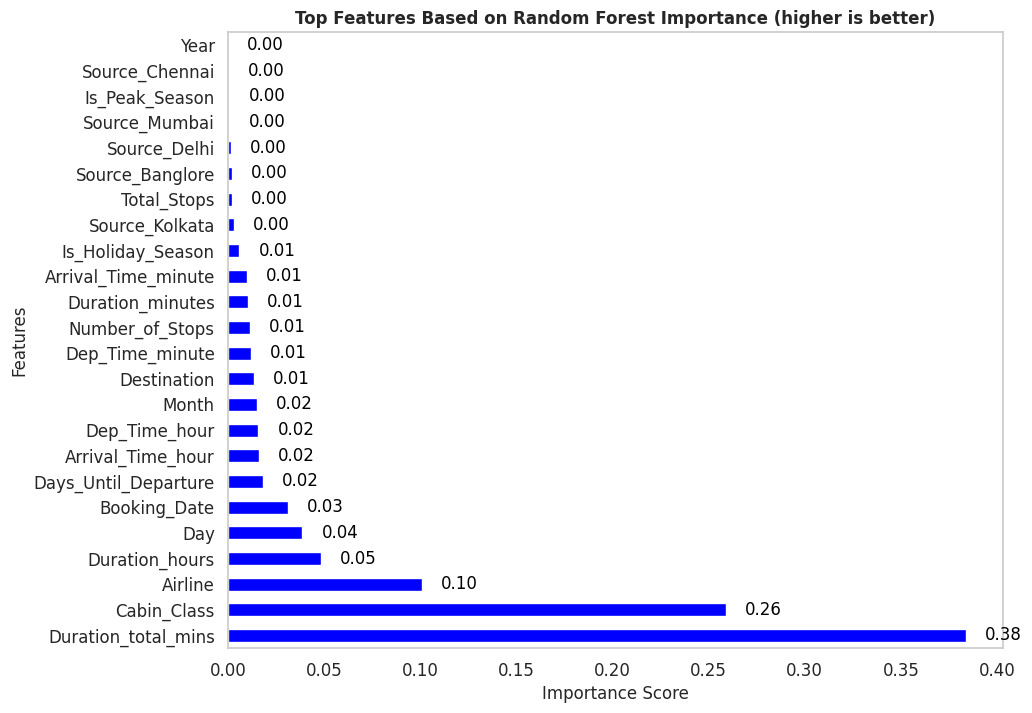

In [105]:
from sklearn.ensemble import RandomForestRegressor
X = data.drop(['Price'], axis=1)  # independent
y = data['Price']  # dependent
### 3. Feature Importance using Random Forest

# Convert 'Booking_Date' to ordinal before fitting the model
X['Booking_Date'] = pd.to_datetime(X['Booking_Date'])  # Ensure it's datetime
X['Booking_Date'] = X['Booking_Date'].apply(lambda date: date.toordinal())

random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X, y)
feature_importance = pd.Series(random_forest_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top  Features based on Random Forest Importance:\n", feature_importance)

# Plot Feature Importances
plt.figure(figsize=(10,8))
feature_importance.plot(kind='barh', color='blue')

# Annotate the values on the bars
for index, value in enumerate(feature_importance):
    plt.text(value + 0.01, index, f'{value:.2f}', ha='left', va='center', fontsize=12, color='black')


plt.title("Top Features Based on Random Forest Importance (higher is better)",fontsize=12,fontweight="bold")
plt.ylabel("Features",fontsize=12)
plt.xlabel("Importance Score",fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(False)
plt.show()

In [106]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression # Import LinearRegression
from sklearn.model_selection import train_test_split  # Import train-test split function
from sklearn.tree import DecisionTreeRegressor  # Import Decision Tree Regressor


In [107]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

ML Pipeline

In [108]:
def predict(ml_model):
    print('Model is: {}'.format(ml_model))

    model= ml_model.fit(X_train,y_train)
    print("Training score: {}".format(model.score(X_train,y_train)))

    predictions = model.predict(X_test)
    print("Predictions are: {}".format(predictions))
    print('\n')

    # Compute Metrics
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"Mean Absolute Percentage Error: {mape:.2f}%\n")





LinearRegression

In [109]:
predict(LinearRegression(fit_intercept=True, positive=False, n_jobs=-1))



Model is: LinearRegression(n_jobs=-1)
Training score: 0.6675765767707071
Predictions are: [16625.52816036  9954.40147051 11465.33319101 ... 10680.59195445
 15220.14852118 10121.58682948]


R² Score: 0.6932
Mean Absolute Error: 1840.20
Mean Squared Error: 6135565.80
Root Mean Squared Error: 2477.01
Mean Absolute Percentage Error: 24.27%



DecisionTreeRegressor

In [110]:
predict(DecisionTreeRegressor(max_depth=10,
    min_samples_split=5,
    random_state=100))

Model is: DecisionTreeRegressor(max_depth=10, min_samples_split=5, random_state=100)
Training score: 0.894053701391484
Predictions are: [19480.92857143 12490.7        11162.00815217 ... 11968.10443038
 15616.18518519 10469.2750533 ]


R² Score: 0.8572
Mean Absolute Error: 1104.30
Mean Squared Error: 2855829.47
Root Mean Squared Error: 1689.92
Mean Absolute Percentage Error: 12.10%



RandomForestRegressor

In [111]:
predict(RandomForestRegressor( n_estimators=100,
    max_depth=10,
    random_state=100))

Model is: RandomForestRegressor(max_depth=10, random_state=100)
Training score: 0.9197686690873228
Predictions are: [18533.96218082 10877.18057929 11305.64605873 ... 12094.35068481
 15981.06508817 10829.47979807]


R² Score: 0.8760
Mean Absolute Error: 1073.40
Mean Squared Error: 2479666.11
Root Mean Squared Error: 1574.70
Mean Absolute Percentage Error: 11.83%



In [112]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor


best hypertune

In [113]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score

# Base model
rf = RandomForestRegressor(random_state=100)

# Optimized smaller search space
param_dist = {
    'n_estimators': [150, 200, 250],
    'max_depth': [10,20,30],
    'min_samples_split': [2, 5, 10]
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=3,           # Only try 5 combinations
    cv=3,               # 3-fold cross-validation
    scoring='r2',
    random_state=100,
    n_jobs=-1,
    verbose=1
)

# Fit the model
random_search.fit(X_train, y_train)

# Predict and evaluate
pred = random_search.best_estimator_.predict(X_test)

# Compute Metrics  -- This block should not be indented
r2 = r2_score(y_test, pred)
mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - pred) / y_test)) * 100

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%\n")

print("Best Parameters:", random_search.best_params_)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
R² Score: 0.8857
Mean Absolute Error: 951.90
Mean Squared Error: 2286722.13
Root Mean Squared Error: 1512.19
Mean Absolute Percentage Error: 10.32%

Best Parameters: {'n_estimators': 150, 'min_samples_split': 2, 'max_depth': 20}


XGBRegressor

In [114]:
from xgboost import XGBRegressor
predict(XGBRegressor(n_estimators=100,learning_rate=0.1,max_depth=5,subsample=0.8,colsample_bytree=0.8,random_state=100))

Model is: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=100, ...)
Training score: 0.9010834693908691
Predictions are: [17334.71   10894.136  11142.125  ... 11489.17   15572.0205 11321.895 ]


R² Score: 0.8686
Mean Absolute Error: 1150.91
Mean Squared Error: 2628773.75
Root Mean Squared Error: 1621.35
Mean Absolute 

GradientBoostingRegressor

In [115]:
from sklearn.ensemble import GradientBoostingRegressor # Import the GradientBoostingRegressor class
predict(GradientBoostingRegressor(n_estimators=100,learning_rate=0.1,max_depth=5,subsample=0.8,random_state=100))

Model is: GradientBoostingRegressor(max_depth=5, random_state=100, subsample=0.8)
Training score: 0.9064063172569887
Predictions are: [16739.05428742 11646.11713392 11200.83833518 ... 11664.85813126
 15485.80079944 11345.04968379]


R² Score: 0.8654
Mean Absolute Error: 1154.91
Mean Squared Error: 2691287.03
Root Mean Squared Error: 1640.51
Mean Absolute Percentage Error: 13.18%



Distribution of Residuals for Different Regression Models

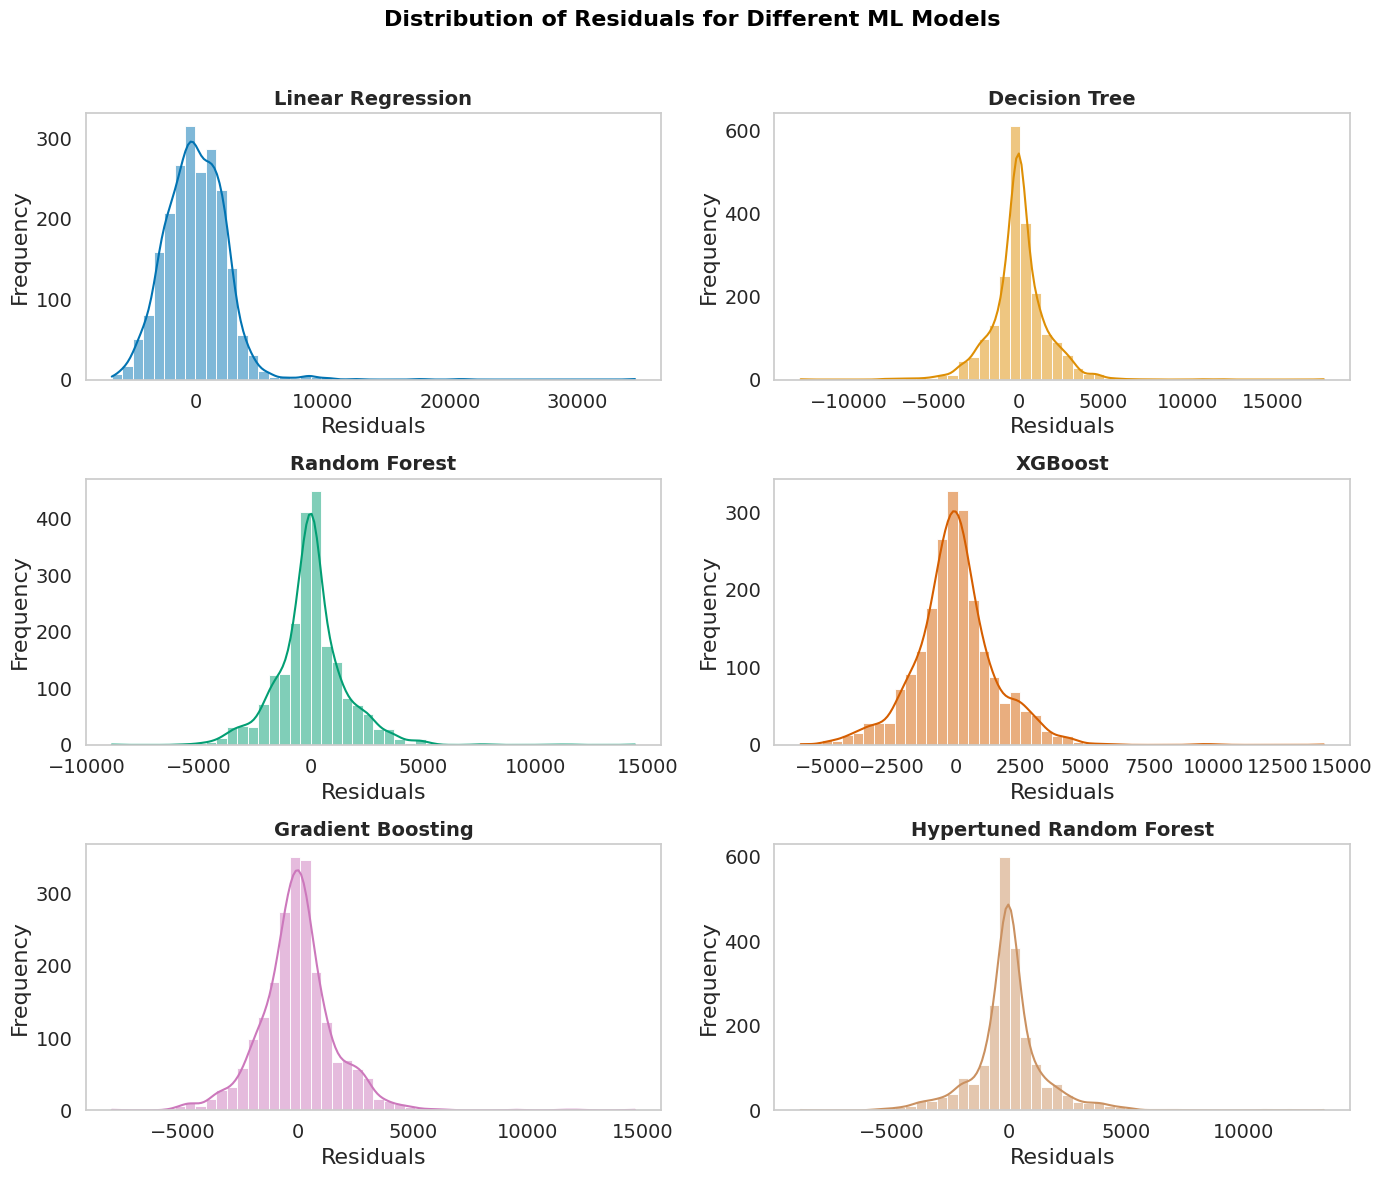

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV # Import RandomizedSearchCV
from xgboost import XGBRegressor

# Set seaborn style for aesthetics
sns.set_style("whitegrid")
#plt.figure(figsize=(14, 12))
# Define the models to be compared
models = {
    "Linear Regression": LinearRegression(fit_intercept=True, positive=False, n_jobs=-1),
    "Decision Tree": DecisionTreeRegressor(max_depth=10,
    min_samples_split=5,
    random_state=100),
    "Random Forest": RandomForestRegressor(n_estimators=100,
    max_depth=10,
    random_state=100),
    "XGBoost": XGBRegressor(n_estimators=100,learning_rate=0.1,max_depth=5,subsample=0.8,colsample_bytree=0.8,random_state=100),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100,learning_rate=0.1,max_depth=5,subsample=0.8,random_state=100),
    "Hypertuned Random Forest": random_search.best_estimator_
 # Access the best estimator using .best_estimator_

}


# Set up the subplot grid
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12)) # Create a grid with 3 rows and 2 columns
fig.suptitle("Distribution of Residuals for Different ML Models", fontsize=16, fontweight="bold",color="black")
axes = axes.flatten()  # Flatten for easy indexing

# Loop through each model, fit it, make predictions, and plot residuals
for idx, (model_name, model) in enumerate(models.items()):
   # Fit the model to the training data (X_train, y_train)
    model.fit(X_train, y_train)

   # Make predictions on the test data (X_test)
    predictions = model.predict(X_test)

      # Calculate residuals (difference between actual values and predicted values)
    residuals = y_test - predictions

    # Plot in the corresponding subplot
    sns.histplot(residuals, kde=True, bins=50, ax=axes[idx], color=sns.color_palette("colorblind")[idx])
    axes[idx].set_title(f"{model_name}", fontsize=14,fontweight='bold')
    axes[idx].set_xlabel("Residuals", fontsize=16)
    axes[idx].set_ylabel("Frequency", fontsize=16)

 # Apply x and y ticks font size inside the loop for each subplot
    axes[idx].tick_params(axis='x', labelsize=14)
    axes[idx].tick_params(axis='y', labelsize=14)
# Remove grid lines
for ax in axes:
    ax.grid(False)
# Hide any unused subplots (if total slots > models)
for j in range(len(models), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make room for the main title
plt.show()


Performance Metrics Comparison of ML Models

Model Performance Metrics:

                                 MSE      MAE      R2     RMSE   MAPE
Linear Regression         6135565.80  1840.20  0.6932  2477.01  24.27
Decision Tree             2855829.47  1104.30  0.8572  1689.92  12.10
Random Forest             2479666.11  1073.40  0.8760  1574.70  11.83
XGBoost                   2628773.75  1150.91  0.8686  1621.35  13.18
Gradient Boosting         2691287.03  1154.91  0.8654  1640.51  13.18
Hypertuned Random Forest  2286722.13   951.90  0.8857  1512.19  10.32


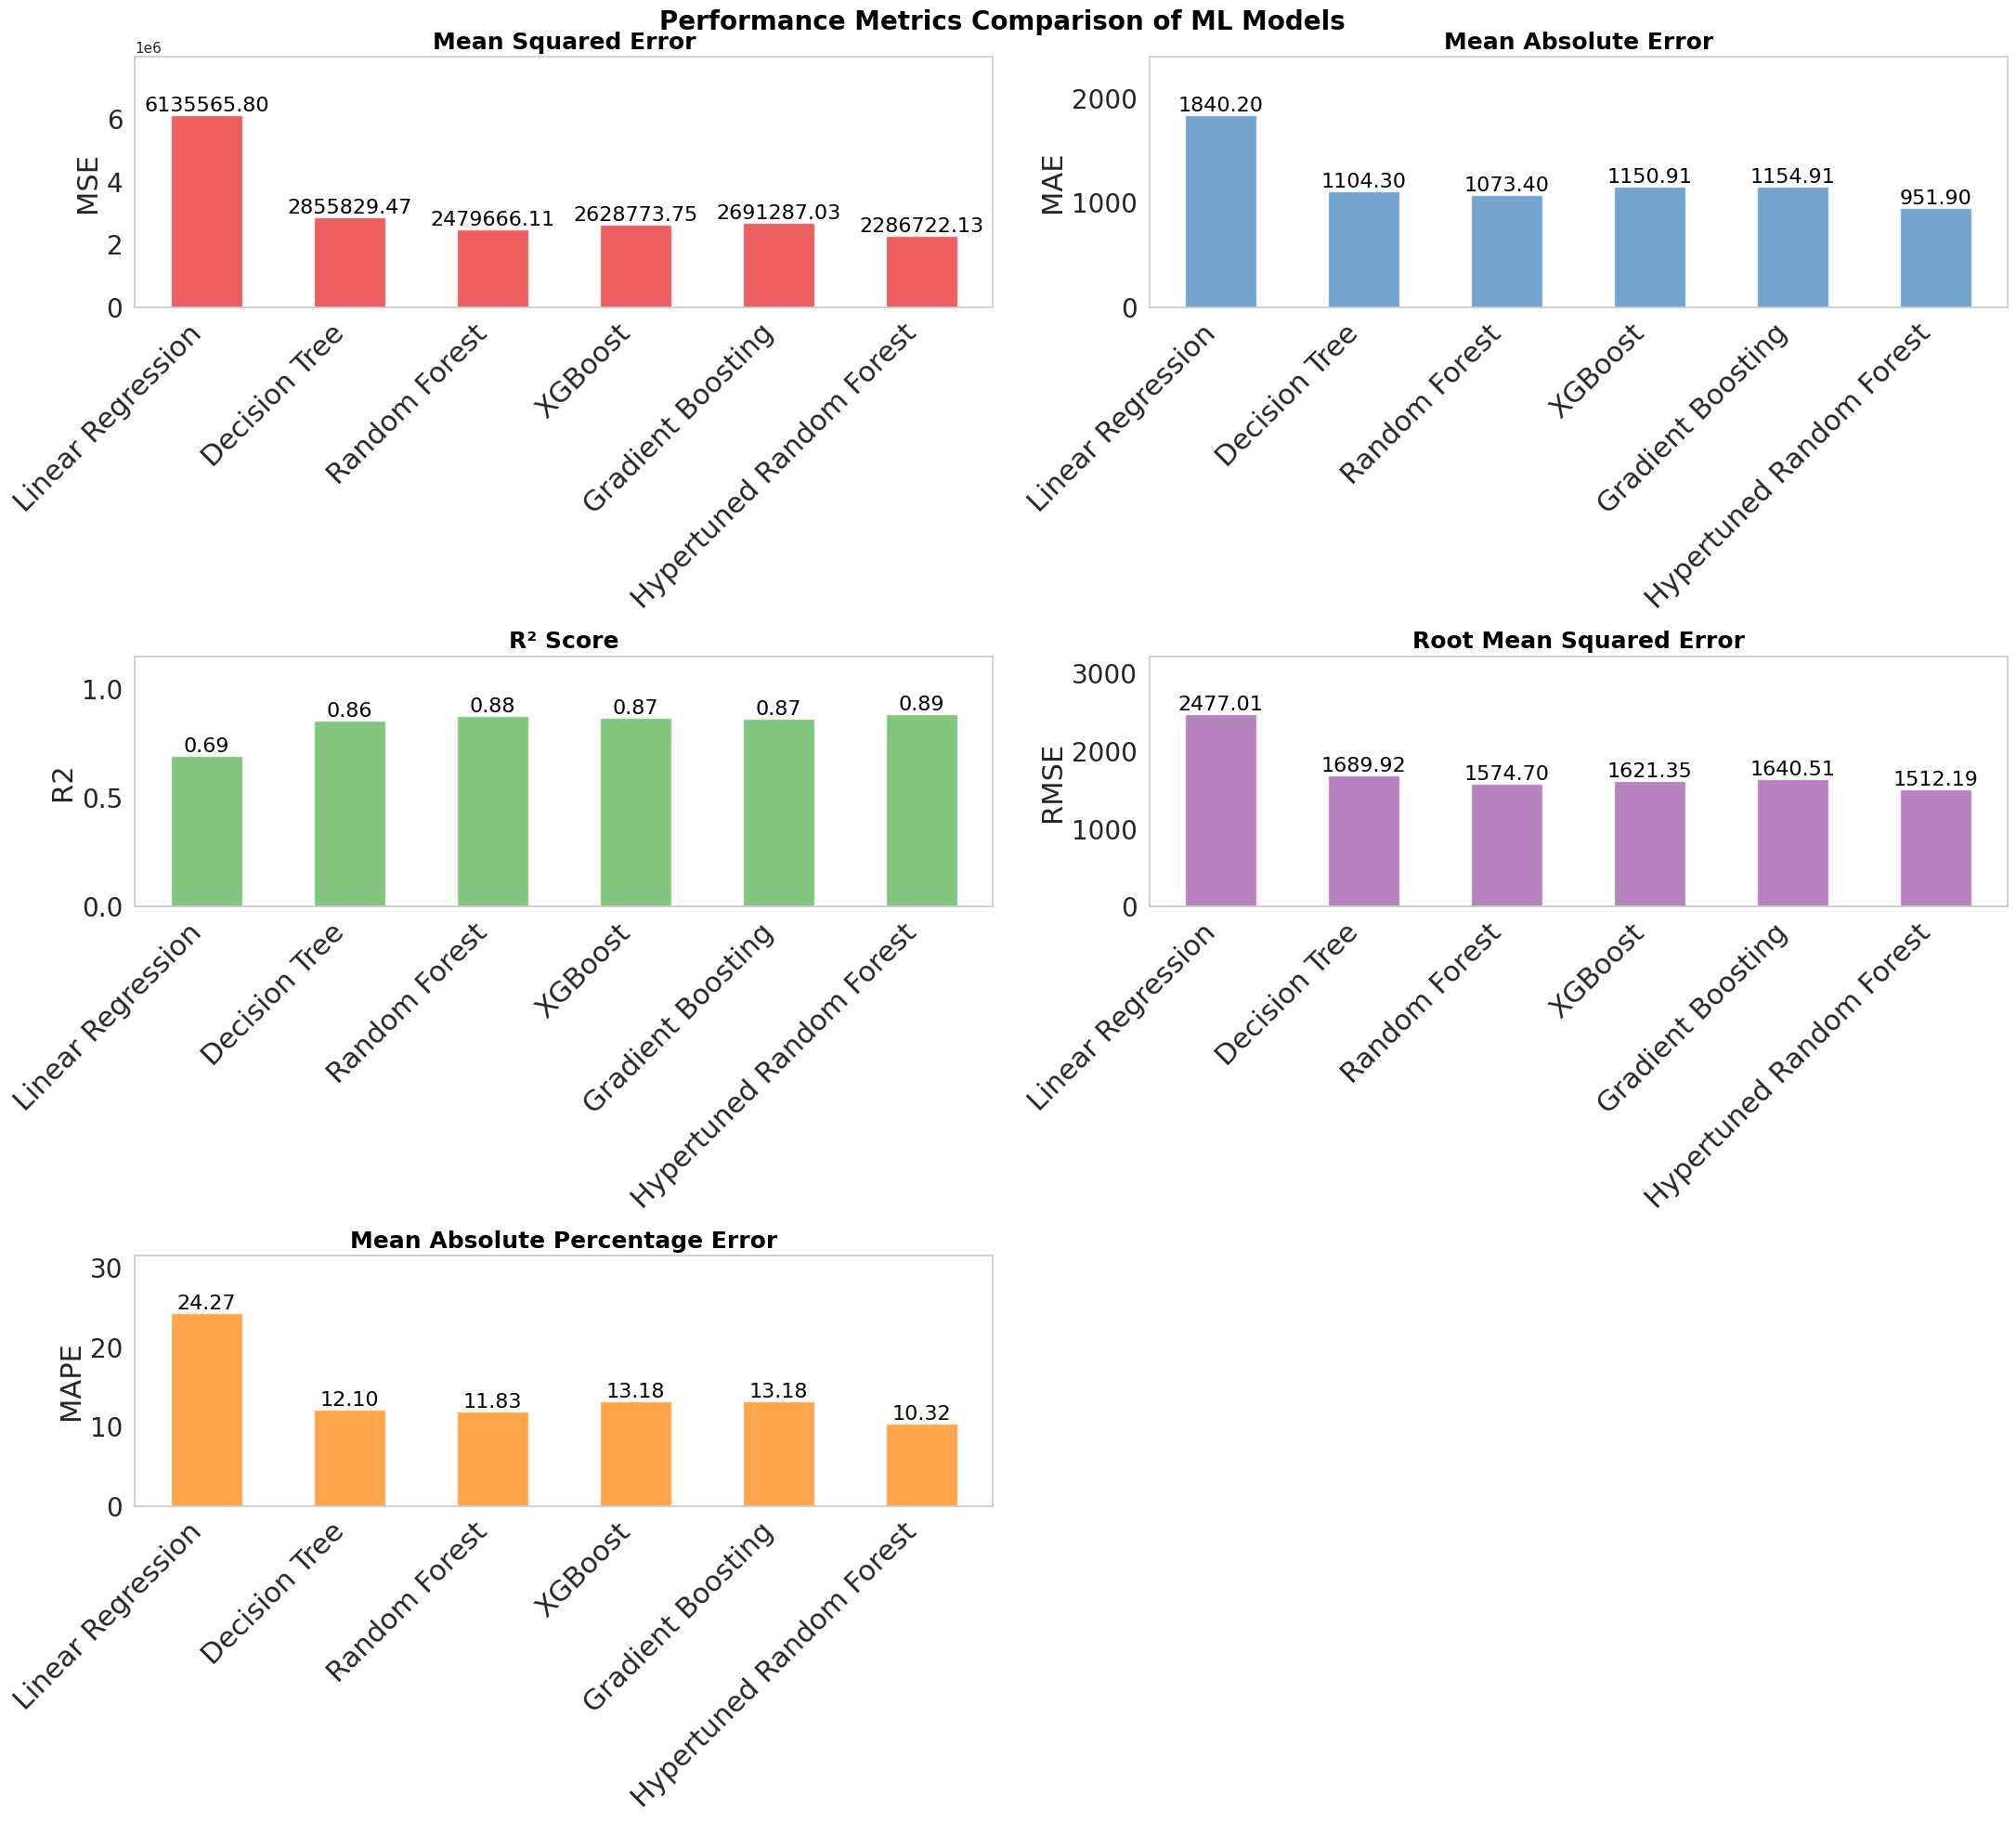

In [117]:
# Define models
models = {
    "Linear Regression": LinearRegression(fit_intercept=True, positive=False, n_jobs=-1),
    "Decision Tree": DecisionTreeRegressor(max_depth=10,
    min_samples_split=5,
    random_state=100),
    "Random Forest": RandomForestRegressor(n_estimators=100,
    max_depth=10,
    random_state=100),
    "XGBoost": XGBRegressor(n_estimators=100,learning_rate=0.1,max_depth=5,subsample=0.8,colsample_bytree=0.8,random_state=100),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100,learning_rate=0.1,max_depth=5,subsample=0.8,random_state=100),
    "Hypertuned Random Forest": random_search.best_estimator_
 # Access the best estimator using .best_estimator_

}

# Store metrics
metrics = {"MSE": [], "MAE": [], "R2": [], "RMSE": [], "MAPE": []}
model_names = []

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    # Compute Metrics
    r2 = r2_score(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    # Handle MAPE carefully to avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):  # Corrected indentation
        mape = np.mean(np.abs((y_test - pred) / y_test)) * 100
        if np.isinf(mape) or np.isnan(mape):
            mape = 0  # or another appropriate value

    # Append calculated metrics
    metrics["MSE"].append(mse)
    metrics["MAE"].append(mae)
    metrics["R2"].append(r2)
    metrics["RMSE"].append(rmse)
    metrics["MAPE"].append(mape)  # Moved inside the loop

    model_names.append(name)

# Define full metric names for better visualization
metric_full_names = {
    "MSE": "Mean Squared Error",
    "MAE": "Mean Absolute Error",
    "R2": "R² Score",
    "RMSE": "Root Mean Squared Error",
    "MAPE": "Mean Absolute Percentage Error"
}


# Convert to DataFrame
df_metrics = pd.DataFrame(metrics, index=model_names)

# Display the performance metrics table
print("Model Performance Metrics:\n")
print(df_metrics.round({'R2': 4, 'MAE': 2, 'MSE': 2, 'RMSE': 2, 'MAPE': 2}))

# Set seaborn style for aesthetics
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(22,20))
fig.suptitle("Performance Metrics Comparison of ML Models", fontsize=20, fontweight="bold",color="black")

metric_names = list(metrics.keys())
colors = sns.color_palette("Set1", 5)  # Using a nice color palette

for i, ax in enumerate(axes.flat[:5]):  # Only using first 5 subplots
    bars = df_metrics[metric_names[i]].plot(kind="bar", ax=ax, color=colors[i], alpha=0.7)

    ax.set_title(metric_full_names[metric_names[i]], fontsize=18, fontweight="bold", color="black")
    ax.set_ylabel(metric_names[i], fontsize=22,)
    ax.set_xticklabels(model_names, rotation=45, ha="right",fontsize=22)
    #ax.yaxis.grid(True, linestyle="--", alpha=0.7)
    ax.tick_params(axis='y', labelsize=20)

    # Adjust the Y-axis height (set the Y limits)
    ax.set_ylim(0, max(df_metrics[metric_names[i]]) * 1.3)  # 20% higher than max value for spacing

    # Add value labels to bars
    for bar in bars.patches:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}',
                ha='center', va='bottom', fontsize=16, color='black')
  # Remove grid lines
    ax.grid(False)
# Hide the empty subplot
axes[2, 1].axis("off")

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


Model Performance Metrics on Training and Testing Sets

In [118]:
# Initialize metrics dictionaries for training and testing
train_metrics = {"MSE": [], "MAE": [], "R2": [], "RMSE": [], "MAPE": []}
test_metrics = {"MSE": [], "MAE": [], "R2": [], "RMSE": [], "MAPE": []}
model_names = []

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Training Metrics
    r2_train = r2_score(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mse_train)
    mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100

    train_metrics["MSE"].append(mse_train)
    train_metrics["MAE"].append(mae_train)
    train_metrics["R2"].append(r2_train)
    train_metrics["RMSE"].append(rmse_train)
    train_metrics["MAPE"].append(mape_train)

    # Testing Metrics
    r2_test = r2_score(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mse_test)
    mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

    test_metrics["MSE"].append(mse_test)
    test_metrics["MAE"].append(mae_test)
    test_metrics["R2"].append(r2_test)
    test_metrics["RMSE"].append(rmse_test)
    test_metrics["MAPE"].append(mape_test)

    model_names.append(name)

# Create DataFrames
df_train = pd.DataFrame(train_metrics, index=model_names).add_suffix(" (Train)")
df_test = pd.DataFrame(test_metrics, index=model_names).add_suffix(" (Test)")

# Combine train and test metrics into one table
df_combined = pd.concat([df_train, df_test], axis=1)

# Display the combined metrics table
print("\nModel Performance Metrics on Training and Testing Sets:\n")
print(df_combined.round(2))



Model Performance Metrics on Training and Testing Sets:

                          MSE (Train)  MAE (Train)  R2 (Train)  RMSE (Train)  \
Linear Regression          7170735.73      1871.27        0.67       2677.82   
Decision Tree              2285377.19       975.23        0.89       1511.75   
Random Forest              1730677.30       921.28        0.92       1315.55   
XGBoost                    2133736.75      1065.15        0.90       1460.73   
Gradient Boosting          2018917.80      1041.35        0.91       1420.89   
Hypertuned Random Forest    454891.83       394.98        0.98        674.46   

                          MAPE (Train)  MSE (Test)  MAE (Test)  R2 (Test)  \
Linear Regression                23.83  6135565.80     1840.20       0.69   
Decision Tree                    10.30  2855829.47     1104.30       0.86   
Random Forest                     9.94  2479666.11     1073.40       0.88   
XGBoost                          11.95  2628773.75     1150.91       0.87

Learning curve

Plotting learning curve for: Linear Regression


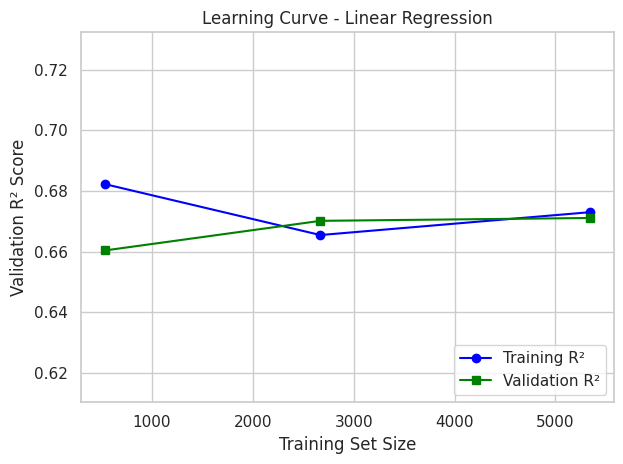

Plotting learning curve for: Decision Tree


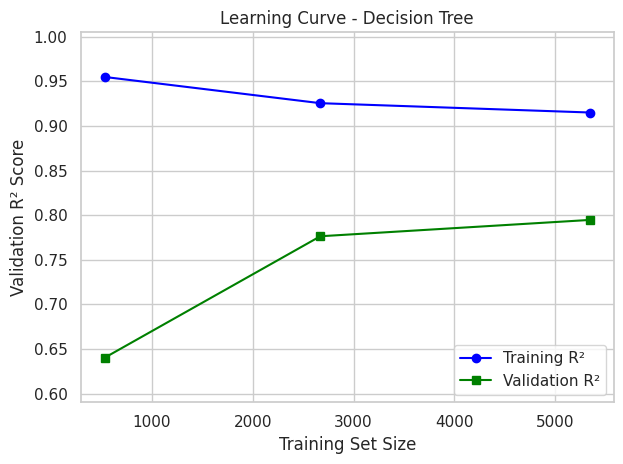

Plotting learning curve for: Random Forest


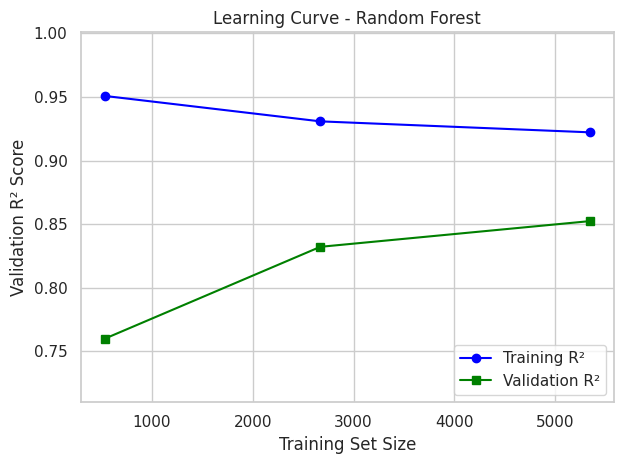

Plotting learning curve for: XGBoost


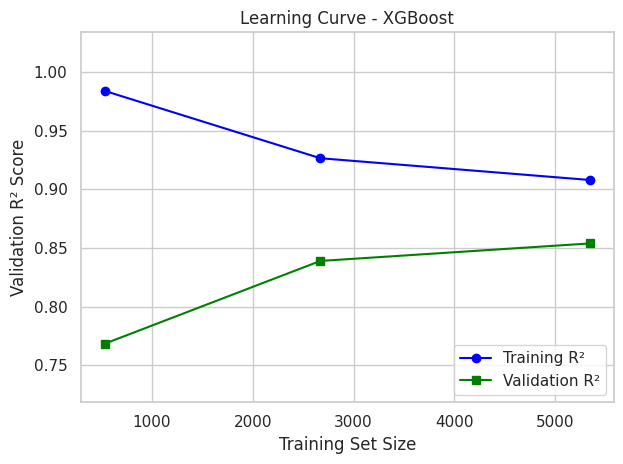

Plotting learning curve for: Gradient Boosting


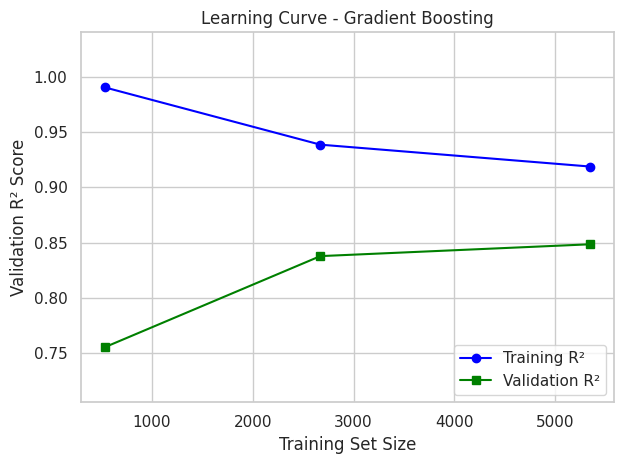

Plotting learning curve for: Hypertuned Random Forest


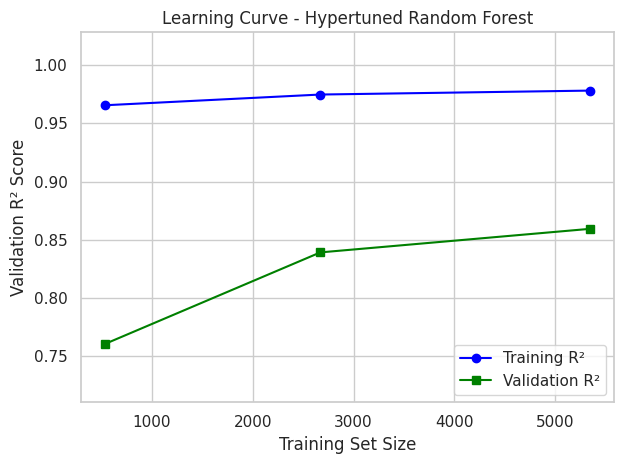

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import pandas as pd

# Preprocessing function
def preprocess_data(X):
    X = X.copy()
    X['Booking_Date'] = pd.to_datetime(X['Booking_Date'])
    X['Booking_Date'] = X['Booking_Date'].apply(lambda date: date.toordinal())
    return X

# Learning curve plotting function
def plot_learning_curve(model, X, y, model_name="Model", cv_folds=2):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator=model,
        X=X,
        y=y,
        train_sizes=[0.1, 0.5, 1.0],  # Fewer points
        cv=KFold(n_splits=cv_folds, shuffle=True, random_state=100),
        scoring='r2',
        n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    plt.plot(train_sizes, train_mean, 'o-', label="Training R²", color='blue')
    plt.plot(train_sizes, val_mean, 's-', label="Validation R²", color='green')

    plt.title(f'Learning Curve - {model_name}')
    plt.xlabel("Training Set Size")
    plt.ylabel("Validation R² Score")
    plt.ylim(min(train_mean.min(), val_mean.min()) - 0.05,
             max(train_mean.max(), val_mean.max()) + 0.05)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Preprocess the dataset
X = preprocess_data(data.drop("Price", axis=1))
y = data["Price"]

# Choose only fast models (or reduce others)
models = {
     "Linear Regression": LinearRegression(fit_intercept=True, positive=False, n_jobs=-1),
    "Decision Tree": DecisionTreeRegressor(max_depth=10,
    min_samples_split=5,
    random_state=100),
    "Random Forest": RandomForestRegressor(n_estimators=100,
    max_depth=10,
    random_state=100),
    "XGBoost": XGBRegressor(n_estimators=100,learning_rate=0.1,max_depth=5,subsample=0.8,colsample_bytree=0.8,random_state=100),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100,learning_rate=0.1,max_depth=5,subsample=0.8,random_state=100),
    "Hypertuned Random Forest": random_search.best_estimator_
}

# Plot learning curves
for name, model in models.items():
    print(f"Plotting learning curve for: {name}")
    plot_learning_curve(model, X, y, model_name=name)


Comparison of ML Models Across Different Metrics values

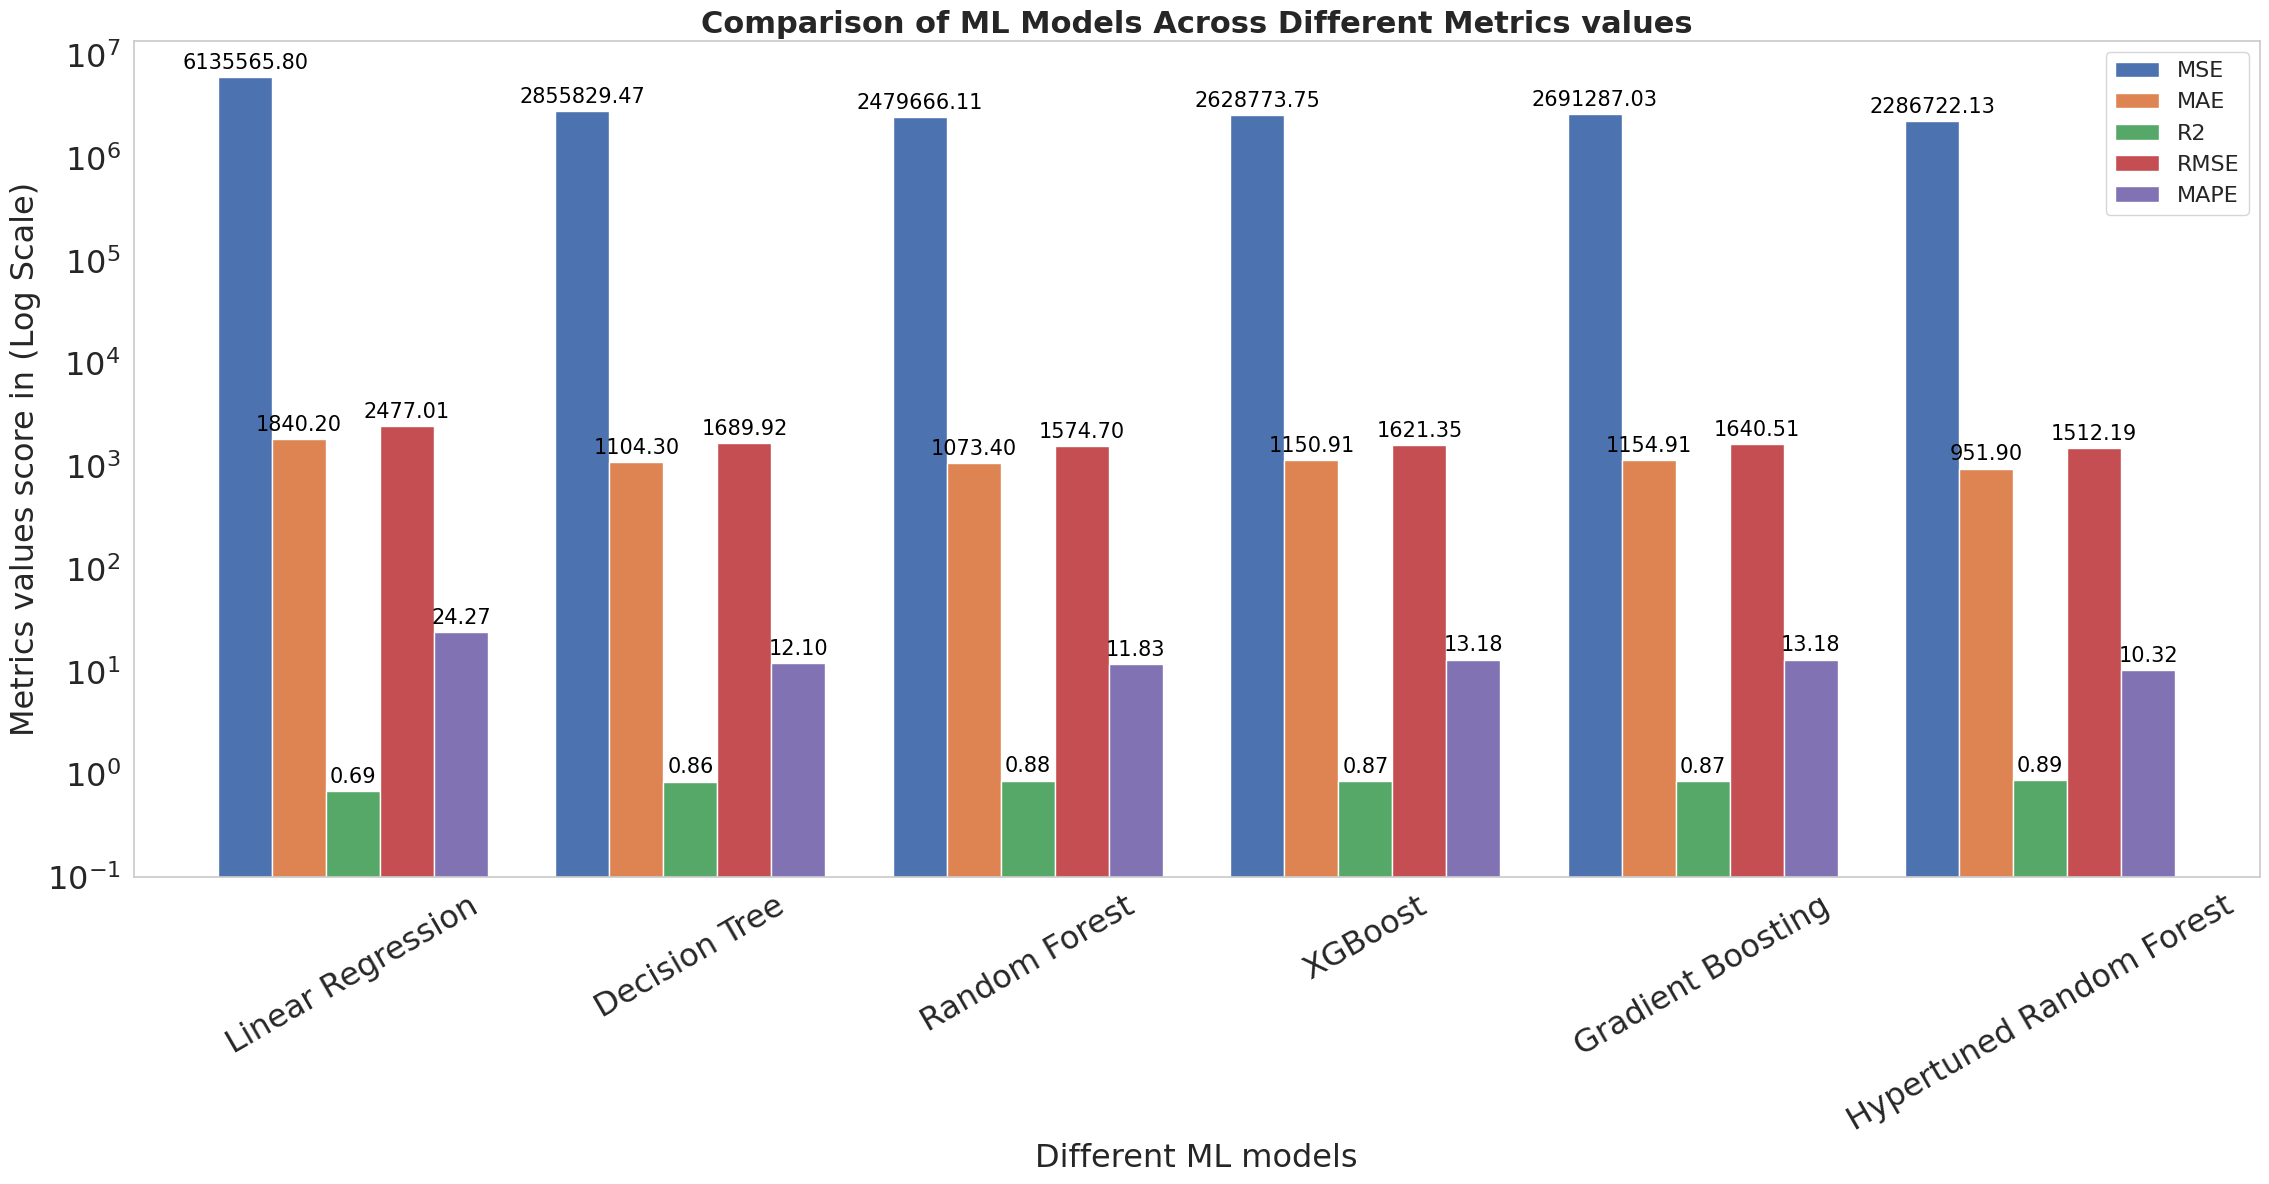

In [120]:
# Assuming you want to plot from the `metrics` dictionary you created
df_plot = pd.DataFrame(metrics, index=model_names)

# Set up the figure and plot the grouped bar chart
fig, ax1 = plt.subplots(figsize=(23,12))

# Plot grouped bar chart with metrics as grouped bars for each model on the primary axis (ax1)
bar_container = df_plot.plot(kind='bar', ax=ax1, width=0.8)

# Title and labels
ax1.set_title("Comparison of ML Models Across Different Metrics values", fontsize=22, fontweight='bold')
ax1.set_xlabel("Different ML models", fontsize=23)
ax1.set_ylabel("Metrics values score in (Log Scale)", fontsize=23)

# X-axis labels (metrics)
ax1.set_xticklabels(df_plot.index, fontsize=18, rotation=30,ha='center')
# Set font size for both X and Y axis tick labels
ax1.tick_params(axis='x', labelsize=23)  # Set X-axis tick label size
ax1.tick_params(axis='y', labelsize=23)  # Set Y-axis tick label size

# Apply log scale to the primary y-axis
ax1.set_yscale('log')  # Apply log scaling for better visualization of larger values like MSE, MAE, RMSE
ax1.set_ylim(bottom=0.1)  # Avoid log scale issues at 0
# Remove grid lines
ax1.grid(False)

# Add value labels to each bar
for bars in bar_container.containers:
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.2f}',  # Value text
                     xy=(bar.get_x() + bar.get_width() / 2, height),  # Position
                     xytext=(0, 3),  # Offset for positioning the label
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=15, color='black')

# Adjust layout to prevent label clipping
plt.legend(loc='upper right', fontsize=16)
plt.tight_layout()
# Show the plot
plt.show()